In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5867 [00:00<?, ?it/s]

  0%|                                                                     | 1/5867 [00:00<53:33,  1.83it/s]

  0%|                                                                     | 7/5867 [00:00<07:12, 13.56it/s]

  0%|▏                                                                   | 13/5867 [00:00<04:10, 23.36it/s]

  0%|▏                                                                   | 19/5867 [00:00<03:10, 30.77it/s]

  0%|▎                                                                   | 25/5867 [00:00<02:38, 36.96it/s]

  1%|▎                                                                   | 31/5867 [00:01<02:22, 40.95it/s]

  1%|▍                                                                   | 37/5867 [00:01<02:10, 44.63it/s]

  1%|▍                                                                   | 43/5867 [00:01<02:05, 46.48it/s]

  1%|▌                                                                   | 49/5867 [00:01<01:59, 48.63it/s]

  1%|▋                                                                   | 55/5867 [00:01<01:57, 49.33it/s]

  1%|▋                                                                   | 61/5867 [00:01<01:54, 50.65it/s]

  1%|▊                                                                   | 67/5867 [00:01<01:54, 50.72it/s]

  1%|▊                                                                   | 73/5867 [00:01<01:52, 51.53it/s]

  1%|▉                                                                   | 79/5867 [00:02<01:52, 51.47it/s]

  1%|▉                                                                   | 85/5867 [00:02<01:52, 51.25it/s]

  2%|█                                                                   | 91/5867 [00:02<01:51, 51.96it/s]

  2%|█                                                                   | 97/5867 [00:02<01:51, 51.60it/s]

  2%|█▏                                                                 | 103/5867 [00:02<01:50, 52.26it/s]

  2%|█▏                                                                 | 109/5867 [00:02<01:51, 51.80it/s]

  2%|█▎                                                                 | 115/5867 [00:02<01:49, 52.49it/s]

  2%|█▍                                                                 | 121/5867 [00:02<01:50, 52.00it/s]

  2%|█▍                                                                 | 127/5867 [00:02<01:49, 52.63it/s]

  2%|█▌                                                                 | 133/5867 [00:03<01:50, 52.06it/s]

  2%|█▌                                                                 | 139/5867 [00:03<01:48, 52.61it/s]

  2%|█▋                                                                 | 145/5867 [00:03<01:49, 52.06it/s]

  3%|█▋                                                                 | 151/5867 [00:03<01:48, 52.50it/s]

  3%|█▊                                                                 | 157/5867 [00:03<01:49, 52.13it/s]

  3%|█▊                                                                 | 163/5867 [00:03<01:50, 51.71it/s]

  3%|█▉                                                                 | 169/5867 [00:03<01:49, 52.26it/s]

  3%|█▉                                                                 | 175/5867 [00:03<01:49, 51.81it/s]

  3%|██                                                                 | 181/5867 [00:03<01:48, 52.43it/s]

  3%|██▏                                                                | 187/5867 [00:04<01:49, 51.93it/s]

  3%|██▏                                                                | 193/5867 [00:04<01:48, 52.53it/s]

  3%|██▎                                                                | 199/5867 [00:04<01:49, 51.99it/s]

  3%|██▎                                                                | 205/5867 [00:04<01:47, 52.50it/s]

  4%|██▍                                                                | 211/5867 [00:04<01:48, 52.01it/s]

  4%|██▍                                                                | 217/5867 [00:04<01:47, 52.59it/s]

  4%|██▌                                                                | 223/5867 [00:04<01:48, 52.08it/s]

  4%|██▌                                                                | 229/5867 [00:04<01:47, 52.50it/s]

  4%|██▋                                                                | 235/5867 [00:05<01:48, 52.12it/s]

  4%|██▊                                                                | 241/5867 [00:05<01:48, 51.73it/s]

  4%|██▊                                                                | 247/5867 [00:05<01:47, 52.33it/s]

  4%|██▉                                                                | 253/5867 [00:05<01:48, 51.89it/s]

  4%|██▉                                                                | 259/5867 [00:05<01:46, 52.51it/s]

  5%|███                                                                | 265/5867 [00:05<01:47, 51.97it/s]

  5%|███                                                                | 271/5867 [00:05<01:46, 52.62it/s]

  5%|███▏                                                               | 277/5867 [00:05<01:47, 52.08it/s]

  5%|███▏                                                               | 283/5867 [00:05<01:46, 52.67it/s]

  5%|███▎                                                               | 289/5867 [00:06<01:47, 52.11it/s]

  5%|███▎                                                               | 295/5867 [00:06<01:45, 52.70it/s]

  5%|███▍                                                               | 301/5867 [00:06<01:46, 52.17it/s]

  5%|███▌                                                               | 307/5867 [00:06<01:45, 52.58it/s]

  5%|███▌                                                               | 313/5867 [00:06<01:46, 52.21it/s]

  5%|███▋                                                               | 319/5867 [00:06<01:47, 51.79it/s]

  6%|███▋                                                               | 325/5867 [00:06<01:45, 52.36it/s]

  6%|███▊                                                               | 331/5867 [00:06<01:46, 51.89it/s]

  6%|███▊                                                               | 337/5867 [00:06<01:45, 52.54it/s]

  6%|███▉                                                               | 343/5867 [00:07<01:46, 52.00it/s]

  6%|███▉                                                               | 349/5867 [00:07<01:44, 52.66it/s]

  6%|████                                                               | 355/5867 [00:07<01:45, 52.13it/s]

  6%|████                                                               | 361/5867 [00:07<01:44, 52.70it/s]

  6%|████▏                                                              | 367/5867 [00:07<01:45, 52.13it/s]

  6%|████▎                                                              | 373/5867 [00:07<01:44, 52.63it/s]

  6%|████▎                                                              | 379/5867 [00:07<01:45, 52.13it/s]

  7%|████▍                                                              | 385/5867 [00:07<01:44, 52.57it/s]

  7%|████▍                                                              | 391/5867 [00:08<01:44, 52.20it/s]

  7%|████▌                                                              | 397/5867 [00:08<01:45, 51.77it/s]

  7%|████▌                                                              | 403/5867 [00:08<01:44, 52.36it/s]

  7%|████▋                                                              | 409/5867 [00:08<01:45, 51.89it/s]

  7%|████▋                                                              | 415/5867 [00:08<01:43, 52.53it/s]

  7%|████▊                                                              | 421/5867 [00:08<01:44, 52.00it/s]

  7%|████▉                                                              | 427/5867 [00:08<01:43, 52.66it/s]

  7%|████▉                                                              | 433/5867 [00:08<01:44, 52.09it/s]

  7%|█████                                                              | 439/5867 [00:08<01:43, 52.64it/s]

  8%|█████                                                              | 445/5867 [00:09<01:44, 52.12it/s]

  8%|█████▏                                                             | 451/5867 [00:09<01:42, 52.67it/s]

  8%|█████▏                                                             | 457/5867 [00:09<01:43, 52.10it/s]

  8%|█████▎                                                             | 463/5867 [00:09<01:42, 52.54it/s]

  8%|█████▎                                                             | 469/5867 [00:09<01:43, 52.17it/s]

  8%|█████▍                                                             | 475/5867 [00:09<01:44, 51.78it/s]

  8%|█████▍                                                             | 481/5867 [00:09<01:42, 52.37it/s]

  8%|█████▌                                                             | 487/5867 [00:09<01:43, 51.92it/s]

  8%|█████▋                                                             | 493/5867 [00:09<01:42, 52.49it/s]

  9%|█████▋                                                             | 499/5867 [00:10<01:43, 51.98it/s]

  9%|█████▊                                                             | 505/5867 [00:10<01:41, 52.65it/s]

  9%|█████▊                                                             | 511/5867 [00:10<01:42, 52.07it/s]

  9%|█████▉                                                             | 517/5867 [00:10<01:41, 52.64it/s]

  9%|█████▉                                                             | 523/5867 [00:10<01:42, 52.10it/s]

  9%|██████                                                             | 529/5867 [00:10<01:41, 52.64it/s]

  9%|██████                                                             | 535/5867 [00:10<01:42, 52.14it/s]

  9%|██████▏                                                            | 541/5867 [00:10<01:41, 52.53it/s]

  9%|██████▏                                                            | 547/5867 [00:10<01:41, 52.19it/s]

  9%|██████▎                                                            | 553/5867 [00:11<01:42, 51.78it/s]

 10%|██████▍                                                            | 559/5867 [00:11<01:41, 52.39it/s]

 10%|██████▍                                                            | 565/5867 [00:11<01:42, 51.90it/s]

 10%|██████▌                                                            | 571/5867 [00:11<01:40, 52.54it/s]

 10%|██████▌                                                            | 577/5867 [00:11<01:41, 51.99it/s]

 10%|██████▋                                                            | 583/5867 [00:11<01:40, 52.66it/s]

 10%|██████▋                                                            | 589/5867 [00:11<01:41, 52.11it/s]

 10%|██████▊                                                            | 595/5867 [00:11<01:40, 52.67it/s]

 10%|██████▊                                                            | 601/5867 [00:12<01:41, 52.11it/s]

 10%|██████▉                                                            | 607/5867 [00:12<01:39, 52.67it/s]

 10%|███████                                                            | 613/5867 [00:12<01:40, 52.12it/s]

 11%|███████                                                            | 619/5867 [00:12<01:39, 52.56it/s]

 11%|███████▏                                                           | 625/5867 [00:12<01:40, 52.19it/s]

 11%|███████▏                                                           | 631/5867 [00:12<01:41, 51.78it/s]

 11%|███████▎                                                           | 637/5867 [00:12<01:39, 52.36it/s]

 11%|███████▎                                                           | 643/5867 [00:12<01:40, 51.89it/s]

 11%|███████▍                                                           | 649/5867 [00:12<01:39, 52.54it/s]

 11%|███████▍                                                           | 655/5867 [00:13<01:40, 52.00it/s]

 11%|███████▌                                                           | 661/5867 [00:13<01:38, 52.63it/s]

 11%|███████▌                                                           | 667/5867 [00:13<01:39, 52.09it/s]

 11%|███████▋                                                           | 673/5867 [00:13<01:38, 52.61it/s]

 12%|███████▊                                                           | 679/5867 [00:13<01:39, 52.09it/s]

 12%|███████▊                                                           | 685/5867 [00:13<01:38, 52.64it/s]

 12%|███████▉                                                           | 691/5867 [00:13<01:39, 52.12it/s]

 12%|███████▉                                                           | 697/5867 [00:13<01:38, 52.53it/s]

 12%|████████                                                           | 703/5867 [00:13<01:38, 52.18it/s]

 12%|████████                                                           | 709/5867 [00:14<01:39, 51.76it/s]

 12%|████████▏                                                          | 715/5867 [00:14<01:38, 52.37it/s]

 12%|████████▏                                                          | 721/5867 [00:14<01:39, 51.90it/s]

 12%|████████▎                                                          | 727/5867 [00:14<01:37, 52.51it/s]

 12%|████████▎                                                          | 733/5867 [00:14<01:38, 52.04it/s]

 13%|████████▍                                                          | 739/5867 [00:14<01:37, 52.70it/s]

 13%|████████▌                                                          | 745/5867 [00:14<01:38, 52.12it/s]

 13%|████████▌                                                          | 751/5867 [00:14<01:37, 52.68it/s]

 13%|████████▋                                                          | 757/5867 [00:15<01:38, 52.12it/s]

 13%|████████▋                                                          | 763/5867 [00:15<01:36, 52.67it/s]

 13%|████████▊                                                          | 769/5867 [00:15<01:37, 52.15it/s]

 13%|████████▊                                                          | 775/5867 [00:15<01:36, 52.56it/s]

 13%|████████▉                                                          | 781/5867 [00:15<01:37, 52.19it/s]

 13%|████████▉                                                          | 787/5867 [00:15<01:38, 51.80it/s]

 14%|█████████                                                          | 793/5867 [00:15<01:36, 52.38it/s]

 14%|█████████                                                          | 799/5867 [00:15<01:37, 51.91it/s]

 14%|█████████▏                                                         | 805/5867 [00:15<01:36, 52.49it/s]

 14%|█████████▎                                                         | 811/5867 [00:16<01:37, 51.98it/s]

 14%|█████████▎                                                         | 817/5867 [00:16<01:35, 52.63it/s]

 14%|█████████▍                                                         | 823/5867 [00:16<01:36, 52.07it/s]

 14%|█████████▍                                                         | 829/5867 [00:16<01:35, 52.64it/s]

 14%|█████████▌                                                         | 835/5867 [00:16<01:36, 52.09it/s]

 14%|█████████▌                                                         | 841/5867 [00:16<01:35, 52.63it/s]

 14%|█████████▋                                                         | 847/5867 [00:16<01:36, 52.12it/s]

 15%|█████████▋                                                         | 853/5867 [00:16<01:35, 52.57it/s]

 15%|█████████▊                                                         | 859/5867 [00:16<01:35, 52.19it/s]

 15%|█████████▉                                                         | 865/5867 [00:17<01:36, 51.77it/s]

 15%|█████████▉                                                         | 871/5867 [00:17<01:35, 52.36it/s]

 15%|██████████                                                         | 877/5867 [00:17<01:36, 51.89it/s]

 15%|██████████                                                         | 883/5867 [00:17<01:34, 52.52it/s]

 15%|██████████▏                                                        | 889/5867 [00:17<01:35, 52.01it/s]

 15%|██████████▏                                                        | 895/5867 [00:17<01:34, 52.67it/s]

 15%|██████████▎                                                        | 901/5867 [00:17<01:35, 52.12it/s]

 15%|██████████▎                                                        | 907/5867 [00:17<01:34, 52.69it/s]

 16%|██████████▍                                                        | 913/5867 [00:17<01:35, 52.13it/s]

 16%|██████████▍                                                        | 919/5867 [00:18<01:34, 52.59it/s]

 16%|██████████▌                                                        | 925/5867 [00:18<01:34, 52.07it/s]

 16%|██████████▋                                                        | 931/5867 [00:18<01:33, 52.52it/s]

 16%|██████████▋                                                        | 937/5867 [00:18<01:34, 52.16it/s]

 16%|██████████▊                                                        | 943/5867 [00:18<01:35, 51.77it/s]

 16%|██████████▊                                                        | 949/5867 [00:18<01:34, 52.30it/s]

 16%|██████████▉                                                        | 955/5867 [00:18<01:34, 51.86it/s]

 16%|██████████▉                                                        | 961/5867 [00:18<01:33, 52.51it/s]

 16%|███████████                                                        | 967/5867 [00:19<01:34, 52.01it/s]

 17%|███████████                                                        | 973/5867 [00:19<01:32, 52.67it/s]

 17%|███████████▏                                                       | 979/5867 [00:19<01:33, 52.08it/s]

 17%|███████████▏                                                       | 985/5867 [00:19<01:32, 52.65it/s]

 17%|███████████▎                                                       | 991/5867 [00:19<01:33, 52.11it/s]

 17%|███████████▍                                                       | 997/5867 [00:19<01:32, 52.68it/s]

 17%|███████████▎                                                      | 1003/5867 [00:19<01:33, 52.18it/s]

 17%|███████████▎                                                      | 1009/5867 [00:19<01:32, 52.58it/s]

 17%|███████████▍                                                      | 1015/5867 [00:19<01:32, 52.18it/s]

 17%|███████████▍                                                      | 1021/5867 [00:20<01:33, 51.78it/s]

 18%|███████████▌                                                      | 1027/5867 [00:20<01:32, 52.36it/s]

 18%|███████████▌                                                      | 1033/5867 [00:20<01:33, 51.88it/s]

 18%|███████████▋                                                      | 1039/5867 [00:20<01:31, 52.48it/s]

 18%|███████████▊                                                      | 1045/5867 [00:20<01:32, 51.95it/s]

 18%|███████████▊                                                      | 1051/5867 [00:20<01:31, 52.60it/s]

 18%|███████████▉                                                      | 1057/5867 [00:20<01:32, 52.03it/s]

 18%|███████████▉                                                      | 1063/5867 [00:20<01:31, 52.70it/s]

 18%|████████████                                                      | 1069/5867 [00:20<01:31, 52.16it/s]

 18%|████████████                                                      | 1075/5867 [00:21<01:30, 52.71it/s]

 18%|████████████▏                                                     | 1081/5867 [00:21<01:31, 52.17it/s]

 19%|████████████▏                                                     | 1087/5867 [00:21<01:30, 52.54it/s]

 19%|████████████▎                                                     | 1093/5867 [00:21<01:31, 52.19it/s]

 19%|████████████▎                                                     | 1099/5867 [00:21<01:32, 51.76it/s]

 19%|████████████▍                                                     | 1105/5867 [00:21<01:30, 52.38it/s]

 19%|████████████▍                                                     | 1111/5867 [00:21<01:31, 51.93it/s]

 19%|████████████▌                                                     | 1117/5867 [00:21<01:30, 52.57it/s]

 19%|████████████▋                                                     | 1123/5867 [00:22<01:31, 52.00it/s]

 19%|████████████▋                                                     | 1129/5867 [00:22<01:29, 52.66it/s]

 19%|████████████▊                                                     | 1135/5867 [00:22<01:30, 52.10it/s]

 19%|████████████▊                                                     | 1141/5867 [00:22<01:29, 52.68it/s]

 20%|████████████▉                                                     | 1147/5867 [00:22<01:30, 52.14it/s]

 20%|████████████▉                                                     | 1153/5867 [00:22<01:29, 52.69it/s]

 20%|█████████████                                                     | 1159/5867 [00:22<01:30, 52.15it/s]

 20%|█████████████                                                     | 1165/5867 [00:22<01:29, 52.56it/s]

 20%|█████████████▏                                                    | 1171/5867 [00:22<01:29, 52.20it/s]

 20%|█████████████▏                                                    | 1177/5867 [00:23<01:30, 51.74it/s]

 20%|█████████████▎                                                    | 1183/5867 [00:23<01:29, 52.32it/s]

 20%|█████████████▍                                                    | 1189/5867 [00:23<01:30, 51.87it/s]

 20%|█████████████▍                                                    | 1195/5867 [00:23<01:28, 52.50it/s]

 20%|█████████████▌                                                    | 1201/5867 [00:23<01:29, 51.97it/s]

 21%|█████████████▌                                                    | 1207/5867 [00:23<01:28, 52.63it/s]

 21%|█████████████▋                                                    | 1213/5867 [00:23<01:29, 52.07it/s]

 21%|█████████████▋                                                    | 1219/5867 [00:23<01:28, 52.64it/s]

 21%|█████████████▊                                                    | 1225/5867 [00:23<01:29, 52.12it/s]

 21%|█████████████▊                                                    | 1231/5867 [00:24<01:28, 52.62it/s]

 21%|█████████████▉                                                    | 1237/5867 [00:24<01:28, 52.09it/s]

 21%|█████████████▉                                                    | 1243/5867 [00:24<01:28, 52.53it/s]

 21%|██████████████                                                    | 1249/5867 [00:24<01:28, 52.15it/s]

 21%|██████████████                                                    | 1255/5867 [00:24<01:29, 51.77it/s]

 21%|██████████████▏                                                   | 1261/5867 [00:24<01:28, 52.31it/s]

 22%|██████████████▎                                                   | 1267/5867 [00:24<01:28, 51.86it/s]

 22%|██████████████▎                                                   | 1273/5867 [00:24<01:27, 52.52it/s]

 22%|██████████████▍                                                   | 1279/5867 [00:24<01:28, 51.99it/s]

 22%|██████████████▍                                                   | 1285/5867 [00:25<01:27, 52.64it/s]

 22%|██████████████▌                                                   | 1291/5867 [00:25<01:27, 52.10it/s]

 22%|██████████████▌                                                   | 1297/5867 [00:25<01:26, 52.68it/s]

 22%|██████████████▋                                                   | 1303/5867 [00:25<01:27, 52.11it/s]

 22%|██████████████▋                                                   | 1309/5867 [00:25<01:26, 52.70it/s]

 22%|██████████████▊                                                   | 1315/5867 [00:25<01:27, 52.19it/s]

 23%|██████████████▊                                                   | 1321/5867 [00:25<01:26, 52.47it/s]

 23%|██████████████▉                                                   | 1327/5867 [00:25<01:27, 52.12it/s]

 23%|██████████████▉                                                   | 1333/5867 [00:26<01:27, 51.74it/s]

 23%|███████████████                                                   | 1339/5867 [00:26<01:26, 52.33it/s]

 23%|███████████████▏                                                  | 1345/5867 [00:26<01:27, 51.88it/s]

 23%|███████████████▏                                                  | 1351/5867 [00:26<01:26, 52.50it/s]

 23%|███████████████▎                                                  | 1357/5867 [00:26<01:26, 51.95it/s]

 23%|███████████████▎                                                  | 1363/5867 [00:26<01:25, 52.63it/s]

 23%|███████████████▍                                                  | 1369/5867 [00:26<01:26, 52.10it/s]

 23%|███████████████▍                                                  | 1375/5867 [00:26<01:25, 52.64it/s]

 24%|███████████████▌                                                  | 1381/5867 [00:26<01:26, 52.10it/s]

 24%|███████████████▌                                                  | 1387/5867 [00:27<01:25, 52.64it/s]

 24%|███████████████▋                                                  | 1393/5867 [00:27<01:25, 52.11it/s]

 24%|███████████████▋                                                  | 1399/5867 [00:27<01:25, 52.54it/s]

 24%|███████████████▊                                                  | 1405/5867 [00:27<01:25, 52.20it/s]

 24%|███████████████▊                                                  | 1411/5867 [00:27<01:26, 51.80it/s]

 24%|███████████████▉                                                  | 1417/5867 [00:27<01:25, 52.31it/s]

 24%|████████████████                                                  | 1423/5867 [00:27<01:25, 51.87it/s]

 24%|████████████████                                                  | 1429/5867 [00:27<01:24, 52.51it/s]

 24%|████████████████▏                                                 | 1435/5867 [00:27<01:25, 51.99it/s]

 25%|████████████████▏                                                 | 1441/5867 [00:28<01:24, 52.64it/s]

 25%|████████████████▎                                                 | 1447/5867 [00:28<01:24, 52.08it/s]

 25%|████████████████▎                                                 | 1453/5867 [00:28<01:23, 52.63it/s]

 25%|████████████████▍                                                 | 1459/5867 [00:28<01:24, 52.09it/s]

 25%|████████████████▍                                                 | 1465/5867 [00:28<01:23, 52.61it/s]

 25%|████████████████▌                                                 | 1471/5867 [00:28<01:24, 52.10it/s]

 25%|████████████████▌                                                 | 1477/5867 [00:28<01:23, 52.53it/s]

 25%|████████████████▋                                                 | 1483/5867 [00:28<01:24, 52.16it/s]

 25%|████████████████▊                                                 | 1489/5867 [00:29<01:24, 51.75it/s]

 25%|████████████████▊                                                 | 1495/5867 [00:29<01:23, 52.31it/s]

 26%|████████████████▉                                                 | 1501/5867 [00:29<01:24, 51.86it/s]

 26%|████████████████▉                                                 | 1507/5867 [00:29<01:23, 52.43it/s]

 26%|█████████████████                                                 | 1513/5867 [00:29<01:23, 51.94it/s]

 26%|█████████████████                                                 | 1519/5867 [00:29<01:22, 52.53it/s]

 26%|█████████████████▏                                                | 1525/5867 [00:29<01:23, 52.01it/s]

 26%|█████████████████▏                                                | 1531/5867 [00:29<01:22, 52.55it/s]

 26%|█████████████████▎                                                | 1537/5867 [00:29<01:23, 52.04it/s]

 26%|█████████████████▎                                                | 1543/5867 [00:30<01:22, 52.54it/s]

 26%|█████████████████▍                                                | 1549/5867 [00:30<01:22, 52.05it/s]

 27%|█████████████████▍                                                | 1555/5867 [00:30<01:22, 52.43it/s]

 27%|█████████████████▌                                                | 1561/5867 [00:30<01:22, 52.10it/s]

 27%|█████████████████▋                                                | 1567/5867 [00:30<01:23, 51.72it/s]

 27%|█████████████████▋                                                | 1573/5867 [00:30<01:22, 52.26it/s]

 27%|█████████████████▊                                                | 1579/5867 [00:30<01:22, 51.82it/s]

 27%|█████████████████▊                                                | 1585/5867 [00:30<01:21, 52.41it/s]

 27%|█████████████████▉                                                | 1591/5867 [00:30<01:22, 51.92it/s]

 27%|█████████████████▉                                                | 1597/5867 [00:31<01:21, 52.53it/s]

 27%|██████████████████                                                | 1603/5867 [00:31<01:22, 51.98it/s]

 27%|██████████████████                                                | 1609/5867 [00:31<01:21, 52.52it/s]

 28%|██████████████████▏                                               | 1615/5867 [00:31<01:21, 52.02it/s]

 28%|██████████████████▏                                               | 1621/5867 [00:31<01:20, 52.54it/s]

 28%|██████████████████▎                                               | 1627/5867 [00:31<01:21, 52.04it/s]

 28%|██████████████████▎                                               | 1633/5867 [00:31<01:20, 52.43it/s]

 28%|██████████████████▍                                               | 1639/5867 [00:31<01:21, 52.10it/s]

 28%|██████████████████▌                                               | 1645/5867 [00:32<01:21, 51.71it/s]

 28%|██████████████████▌                                               | 1651/5867 [00:32<01:20, 52.26it/s]

 28%|██████████████████▋                                               | 1657/5867 [00:32<01:21, 51.83it/s]

 28%|██████████████████▋                                               | 1663/5867 [00:32<01:20, 52.36it/s]

 28%|██████████████████▊                                               | 1669/5867 [00:32<01:20, 51.98it/s]

 29%|██████████████████▊                                               | 1675/5867 [00:32<01:19, 52.58it/s]

 29%|██████████████████▉                                               | 1681/5867 [00:32<01:20, 52.03it/s]

 29%|██████████████████▉                                               | 1687/5867 [00:32<01:19, 52.57it/s]

 29%|███████████████████                                               | 1693/5867 [00:32<01:20, 52.07it/s]

 29%|███████████████████                                               | 1699/5867 [00:33<01:19, 52.58it/s]

 29%|███████████████████▏                                              | 1705/5867 [00:33<01:19, 52.06it/s]

 29%|███████████████████▏                                              | 1711/5867 [00:33<01:19, 52.47it/s]

 29%|███████████████████▎                                              | 1717/5867 [00:33<01:19, 52.13it/s]

 29%|███████████████████▍                                              | 1723/5867 [00:33<01:20, 51.73it/s]

 29%|███████████████████▍                                              | 1729/5867 [00:33<01:19, 52.27it/s]

 30%|███████████████████▌                                              | 1735/5867 [00:33<01:19, 51.83it/s]

 30%|███████████████████▌                                              | 1741/5867 [00:33<01:18, 52.42it/s]

 30%|███████████████████▋                                              | 1747/5867 [00:33<01:19, 51.92it/s]

 30%|███████████████████▋                                              | 1753/5867 [00:34<01:18, 52.56it/s]

 30%|███████████████████▊                                              | 1759/5867 [00:34<01:18, 52.03it/s]

 30%|███████████████████▊                                              | 1765/5867 [00:34<01:18, 52.53it/s]

 30%|███████████████████▉                                              | 1771/5867 [00:34<01:18, 52.02it/s]

 30%|███████████████████▉                                              | 1777/5867 [00:34<01:17, 52.57it/s]

 30%|████████████████████                                              | 1783/5867 [00:34<01:18, 52.04it/s]

 30%|████████████████████▏                                             | 1789/5867 [00:34<01:17, 52.44it/s]

 31%|████████████████████▏                                             | 1795/5867 [00:34<01:18, 52.06it/s]

 31%|████████████████████▎                                             | 1801/5867 [00:34<01:18, 51.69it/s]

 31%|████████████████████▎                                             | 1807/5867 [00:35<01:17, 52.25it/s]

 31%|████████████████████▍                                             | 1813/5867 [00:35<01:18, 51.82it/s]

 31%|████████████████████▍                                             | 1819/5867 [00:35<01:17, 52.45it/s]

 31%|████████████████████▌                                             | 1825/5867 [00:35<01:17, 51.95it/s]

 31%|████████████████████▌                                             | 1831/5867 [00:35<01:16, 52.59it/s]

 31%|████████████████████▋                                             | 1837/5867 [00:35<01:17, 52.05it/s]

 31%|████████████████████▋                                             | 1843/5867 [00:35<01:16, 52.60it/s]

 32%|████████████████████▊                                             | 1849/5867 [00:35<01:17, 52.10it/s]

 32%|████████████████████▊                                             | 1855/5867 [00:36<01:16, 52.62it/s]

 32%|████████████████████▉                                             | 1861/5867 [00:36<01:16, 52.10it/s]

 32%|█████████████████████                                             | 1867/5867 [00:36<01:16, 52.49it/s]

 32%|█████████████████████                                             | 1873/5867 [00:36<01:16, 52.20it/s]

 32%|█████████████████████▏                                            | 1879/5867 [00:36<01:16, 51.80it/s]

 32%|█████████████████████▏                                            | 1885/5867 [00:36<01:15, 52.40it/s]

 32%|█████████████████████▎                                            | 1891/5867 [00:36<01:16, 51.94it/s]

 32%|█████████████████████▎                                            | 1897/5867 [00:36<01:15, 52.56it/s]

 32%|█████████████████████▍                                            | 1903/5867 [00:36<01:16, 52.02it/s]

 33%|█████████████████████▍                                            | 1909/5867 [00:37<01:15, 52.66it/s]

 33%|█████████████████████▌                                            | 1915/5867 [00:37<01:15, 52.12it/s]

 33%|█████████████████████▌                                            | 1921/5867 [00:37<01:14, 52.68it/s]

 33%|█████████████████████▋                                            | 1927/5867 [00:37<01:15, 52.12it/s]

 33%|█████████████████████▋                                            | 1933/5867 [00:37<01:14, 52.67it/s]

 33%|█████████████████████▊                                            | 1939/5867 [00:37<01:15, 52.10it/s]

 33%|█████████████████████▉                                            | 1945/5867 [00:37<01:14, 52.58it/s]

 33%|█████████████████████▉                                            | 1951/5867 [00:37<01:14, 52.23it/s]

 33%|██████████████████████                                            | 1957/5867 [00:37<01:15, 51.81it/s]

 33%|██████████████████████                                            | 1963/5867 [00:38<01:14, 52.35it/s]

 34%|██████████████████████▏                                           | 1969/5867 [00:38<01:15, 51.89it/s]

 34%|██████████████████████▏                                           | 1975/5867 [00:38<01:14, 52.53it/s]

 34%|██████████████████████▎                                           | 1981/5867 [00:38<01:14, 51.98it/s]

 34%|██████████████████████▎                                           | 1987/5867 [00:38<01:13, 52.64it/s]

 34%|██████████████████████▍                                           | 1993/5867 [00:38<01:14, 52.09it/s]

 34%|██████████████████████▍                                           | 1999/5867 [00:38<01:13, 52.67it/s]

 34%|██████████████████████▌                                           | 2005/5867 [00:38<01:14, 52.11it/s]

 34%|██████████████████████▌                                           | 2011/5867 [00:39<01:13, 52.67it/s]

 34%|██████████████████████▋                                           | 2017/5867 [00:39<01:13, 52.13it/s]

 34%|██████████████████████▊                                           | 2023/5867 [00:39<01:13, 52.56it/s]

 35%|██████████████████████▊                                           | 2029/5867 [00:39<01:13, 52.20it/s]

 35%|██████████████████████▉                                           | 2035/5867 [00:39<01:13, 51.79it/s]

 35%|██████████████████████▉                                           | 2041/5867 [00:39<01:13, 52.40it/s]

 35%|███████████████████████                                           | 2047/5867 [00:39<01:13, 51.93it/s]

 35%|███████████████████████                                           | 2053/5867 [00:39<01:12, 52.53it/s]

 35%|███████████████████████▏                                          | 2059/5867 [00:39<01:13, 52.00it/s]

 35%|███████████████████████▏                                          | 2065/5867 [00:40<01:12, 52.68it/s]

 35%|███████████████████████▎                                          | 2071/5867 [00:40<01:12, 52.11it/s]

 35%|███████████████████████▎                                          | 2077/5867 [00:40<01:11, 52.67it/s]

 36%|███████████████████████▍                                          | 2083/5867 [00:40<01:12, 52.08it/s]

 36%|███████████████████████▍                                          | 2089/5867 [00:40<01:11, 52.63it/s]

 36%|███████████████████████▌                                          | 2095/5867 [00:40<01:12, 52.09it/s]

 36%|███████████████████████▋                                          | 2101/5867 [00:40<01:11, 52.53it/s]

 36%|███████████████████████▋                                          | 2107/5867 [00:40<01:11, 52.23it/s]

 36%|███████████████████████▊                                          | 2113/5867 [00:40<01:12, 51.76it/s]

 36%|███████████████████████▊                                          | 2119/5867 [00:41<01:11, 52.32it/s]

 36%|███████████████████████▉                                          | 2125/5867 [00:41<01:12, 51.87it/s]

 36%|███████████████████████▉                                          | 2131/5867 [00:41<01:11, 52.48it/s]

 36%|████████████████████████                                          | 2137/5867 [00:41<01:11, 51.93it/s]

 37%|████████████████████████                                          | 2143/5867 [00:41<01:10, 52.55it/s]

 37%|████████████████████████▏                                         | 2149/5867 [00:41<01:11, 52.03it/s]

 37%|████████████████████████▏                                         | 2155/5867 [00:41<01:10, 52.60it/s]

 37%|████████████████████████▎                                         | 2161/5867 [00:41<01:11, 52.06it/s]

 37%|████████████████████████▍                                         | 2167/5867 [00:41<01:10, 52.58it/s]

 37%|████████████████████████▍                                         | 2173/5867 [00:42<01:10, 52.08it/s]

 37%|████████████████████████▌                                         | 2179/5867 [00:42<01:10, 52.49it/s]

 37%|████████████████████████▌                                         | 2185/5867 [00:42<01:10, 52.15it/s]

 37%|████████████████████████▋                                         | 2191/5867 [00:42<01:11, 51.71it/s]

 37%|████████████████████████▋                                         | 2197/5867 [00:42<01:10, 52.25it/s]

 38%|████████████████████████▊                                         | 2203/5867 [00:42<01:10, 51.82it/s]

 38%|████████████████████████▊                                         | 2209/5867 [00:42<01:09, 52.42it/s]

 38%|████████████████████████▉                                         | 2215/5867 [00:42<01:10, 51.93it/s]

 38%|████████████████████████▉                                         | 2221/5867 [00:43<01:09, 52.57it/s]

 38%|█████████████████████████                                         | 2227/5867 [00:43<01:09, 52.02it/s]

 38%|█████████████████████████                                         | 2233/5867 [00:43<01:09, 52.57it/s]

 38%|█████████████████████████▏                                        | 2239/5867 [00:43<01:09, 52.05it/s]

 38%|█████████████████████████▎                                        | 2245/5867 [00:43<01:08, 52.58it/s]

 38%|█████████████████████████▎                                        | 2251/5867 [00:43<01:09, 52.07it/s]

 38%|█████████████████████████▍                                        | 2257/5867 [00:43<01:08, 52.49it/s]

 39%|█████████████████████████▍                                        | 2263/5867 [00:43<01:09, 52.14it/s]

 39%|█████████████████████████▌                                        | 2269/5867 [00:43<01:09, 51.73it/s]

 39%|█████████████████████████▌                                        | 2275/5867 [00:44<01:08, 52.31it/s]

 39%|█████████████████████████▋                                        | 2281/5867 [00:44<01:09, 51.85it/s]

 39%|█████████████████████████▋                                        | 2287/5867 [00:44<01:08, 52.47it/s]

 39%|█████████████████████████▊                                        | 2293/5867 [00:44<01:08, 51.93it/s]

 39%|█████████████████████████▊                                        | 2299/5867 [00:44<01:07, 52.57it/s]

 39%|█████████████████████████▉                                        | 2305/5867 [00:44<01:08, 52.07it/s]

 39%|█████████████████████████▉                                        | 2311/5867 [00:44<01:07, 52.60it/s]

 39%|██████████████████████████                                        | 2317/5867 [00:44<01:08, 52.09it/s]

 40%|██████████████████████████▏                                       | 2323/5867 [00:44<01:07, 52.62it/s]

 40%|██████████████████████████▏                                       | 2329/5867 [00:45<01:07, 52.06it/s]

 40%|██████████████████████████▎                                       | 2335/5867 [00:45<01:07, 52.46it/s]

 40%|██████████████████████████▎                                       | 2341/5867 [00:45<01:07, 52.12it/s]

 40%|██████████████████████████▍                                       | 2347/5867 [00:45<01:08, 51.73it/s]

 40%|██████████████████████████▍                                       | 2353/5867 [00:45<01:07, 52.27it/s]

 40%|██████████████████████████▌                                       | 2359/5867 [00:45<01:07, 51.83it/s]

 40%|██████████████████████████▌                                       | 2365/5867 [00:45<01:06, 52.46it/s]

 40%|██████████████████████████▋                                       | 2371/5867 [00:45<01:06, 52.91it/s]

 41%|██████████████████████████▋                                       | 2377/5867 [00:46<01:05, 53.44it/s]

 41%|██████████████████████████▊                                       | 2383/5867 [00:46<01:06, 52.62it/s]

 41%|██████████████████████████▊                                       | 2389/5867 [00:46<01:05, 52.98it/s]

 41%|██████████████████████████▉                                       | 2395/5867 [00:46<01:06, 52.39it/s]

 41%|███████████████████████████                                       | 2401/5867 [00:46<01:05, 52.71it/s]

 41%|███████████████████████████                                       | 2407/5867 [00:46<01:06, 52.32it/s]

 41%|███████████████████████████▏                                      | 2413/5867 [00:46<01:06, 51.86it/s]

 41%|███████████████████████████▏                                      | 2419/5867 [00:46<01:05, 52.40it/s]

 41%|███████████████████████████▎                                      | 2425/5867 [00:46<01:06, 51.93it/s]

 41%|███████████████████████████▎                                      | 2431/5867 [00:47<01:05, 52.49it/s]

 42%|███████████████████████████▍                                      | 2437/5867 [00:47<01:05, 51.99it/s]

 42%|███████████████████████████▍                                      | 2443/5867 [00:47<01:05, 52.61it/s]

 42%|███████████████████████████▌                                      | 2449/5867 [00:47<01:05, 52.08it/s]

 42%|███████████████████████████▌                                      | 2455/5867 [00:47<01:04, 52.62it/s]

 42%|███████████████████████████▋                                      | 2461/5867 [00:47<01:05, 52.12it/s]

 42%|███████████████████████████▊                                      | 2467/5867 [00:47<01:04, 52.62it/s]

 42%|███████████████████████████▊                                      | 2473/5867 [00:47<01:05, 52.08it/s]

 42%|███████████████████████████▉                                      | 2479/5867 [00:47<01:04, 52.49it/s]

 42%|███████████████████████████▉                                      | 2485/5867 [00:48<01:04, 52.15it/s]

 42%|████████████████████████████                                      | 2491/5867 [00:48<01:05, 51.75it/s]

 43%|████████████████████████████                                      | 2497/5867 [00:48<01:04, 52.32it/s]

 43%|████████████████████████████▏                                     | 2503/5867 [00:48<01:04, 51.88it/s]

 43%|████████████████████████████▏                                     | 2509/5867 [00:48<01:04, 52.47it/s]

 43%|████████████████████████████▎                                     | 2515/5867 [00:48<01:04, 51.94it/s]

 43%|████████████████████████████▎                                     | 2521/5867 [00:48<01:03, 52.57it/s]

 43%|████████████████████████████▍                                     | 2527/5867 [00:48<01:04, 52.03it/s]

 43%|████████████████████████████▍                                     | 2533/5867 [00:48<01:03, 52.56it/s]

 43%|████████████████████████████▌                                     | 2539/5867 [00:49<01:03, 52.08it/s]

 43%|████████████████████████████▋                                     | 2545/5867 [00:49<01:03, 52.62it/s]

 43%|████████████████████████████▋                                     | 2551/5867 [00:49<01:03, 52.09it/s]

 44%|████████████████████████████▊                                     | 2557/5867 [00:49<01:03, 52.48it/s]

 44%|████████████████████████████▊                                     | 2563/5867 [00:49<01:03, 52.16it/s]

 44%|████████████████████████████▉                                     | 2569/5867 [00:49<01:03, 51.76it/s]

 44%|████████████████████████████▉                                     | 2575/5867 [00:49<01:02, 52.33it/s]

 44%|█████████████████████████████                                     | 2581/5867 [00:49<01:03, 51.85it/s]

 44%|█████████████████████████████                                     | 2587/5867 [00:50<01:02, 52.47it/s]

 44%|█████████████████████████████▏                                    | 2593/5867 [00:50<01:02, 51.99it/s]

 44%|█████████████████████████████▏                                    | 2599/5867 [00:50<01:02, 52.59it/s]

 44%|█████████████████████████████▎                                    | 2605/5867 [00:50<01:02, 52.07it/s]

 45%|█████████████████████████████▎                                    | 2611/5867 [00:50<01:01, 52.61it/s]

 45%|█████████████████████████████▍                                    | 2617/5867 [00:50<01:02, 52.10it/s]

 45%|█████████████████████████████▌                                    | 2623/5867 [00:50<01:01, 52.63it/s]

 45%|█████████████████████████████▌                                    | 2629/5867 [00:50<01:02, 52.10it/s]

 45%|█████████████████████████████▋                                    | 2635/5867 [00:50<01:01, 52.52it/s]

 45%|█████████████████████████████▋                                    | 2641/5867 [00:51<01:01, 52.16it/s]

 45%|█████████████████████████████▊                                    | 2647/5867 [00:51<01:02, 51.77it/s]

 45%|█████████████████████████████▊                                    | 2653/5867 [00:51<01:01, 52.33it/s]

 45%|█████████████████████████████▉                                    | 2659/5867 [00:51<01:01, 51.90it/s]

 45%|█████████████████████████████▉                                    | 2665/5867 [00:51<01:01, 52.48it/s]

 46%|██████████████████████████████                                    | 2671/5867 [00:51<01:00, 53.08it/s]

 46%|██████████████████████████████                                    | 2677/5867 [00:51<00:59, 53.35it/s]

 46%|██████████████████████████████▏                                   | 2683/5867 [00:51<01:00, 52.57it/s]

 46%|██████████████████████████████▏                                   | 2689/5867 [00:51<01:00, 52.94it/s]

 46%|██████████████████████████████▎                                   | 2695/5867 [00:52<01:00, 52.29it/s]

 46%|██████████████████████████████▍                                   | 2701/5867 [00:52<01:00, 52.65it/s]

 46%|██████████████████████████████▍                                   | 2707/5867 [00:52<01:00, 52.26it/s]

 46%|██████████████████████████████▌                                   | 2713/5867 [00:52<01:00, 51.81it/s]

 46%|██████████████████████████████▌                                   | 2719/5867 [00:52<01:00, 52.35it/s]

 46%|██████████████████████████████▋                                   | 2725/5867 [00:52<01:00, 51.91it/s]

 47%|██████████████████████████████▋                                   | 2731/5867 [00:52<00:59, 52.51it/s]

 47%|██████████████████████████████▊                                   | 2737/5867 [00:52<01:00, 52.01it/s]

 47%|██████████████████████████████▊                                   | 2743/5867 [00:53<00:59, 52.64it/s]

 47%|██████████████████████████████▉                                   | 2749/5867 [00:53<00:59, 52.08it/s]

 47%|██████████████████████████████▉                                   | 2755/5867 [00:53<00:59, 52.60it/s]

 47%|███████████████████████████████                                   | 2761/5867 [00:53<00:59, 52.07it/s]

 47%|███████████████████████████████▏                                  | 2767/5867 [00:53<00:58, 52.60it/s]

 47%|███████████████████████████████▏                                  | 2773/5867 [00:53<00:59, 52.08it/s]

 47%|███████████████████████████████▎                                  | 2779/5867 [00:53<00:58, 52.47it/s]

 47%|███████████████████████████████▎                                  | 2785/5867 [00:53<00:59, 52.13it/s]

 48%|███████████████████████████████▍                                  | 2791/5867 [00:53<00:59, 51.70it/s]

 48%|███████████████████████████████▍                                  | 2797/5867 [00:54<00:58, 52.29it/s]

 48%|███████████████████████████████▌                                  | 2803/5867 [00:54<00:59, 51.84it/s]

 48%|███████████████████████████████▌                                  | 2809/5867 [00:54<00:58, 52.46it/s]

 48%|███████████████████████████████▋                                  | 2815/5867 [00:54<00:58, 51.95it/s]

 48%|███████████████████████████████▋                                  | 2821/5867 [00:54<00:57, 52.58it/s]

 48%|███████████████████████████████▊                                  | 2827/5867 [00:54<00:58, 52.04it/s]

 48%|███████████████████████████████▊                                  | 2833/5867 [00:54<00:57, 52.59it/s]

 48%|███████████████████████████████▉                                  | 2839/5867 [00:54<00:58, 52.08it/s]

 48%|████████████████████████████████                                  | 2845/5867 [00:54<00:57, 52.60it/s]

 49%|████████████████████████████████                                  | 2851/5867 [00:55<00:57, 52.08it/s]

 49%|████████████████████████████████▏                                 | 2857/5867 [00:55<00:57, 52.47it/s]

 49%|████████████████████████████████▏                                 | 2863/5867 [00:55<00:57, 52.15it/s]

 49%|████████████████████████████████▎                                 | 2869/5867 [00:55<00:57, 51.74it/s]

 49%|████████████████████████████████▎                                 | 2875/5867 [00:55<00:57, 52.31it/s]

 49%|████████████████████████████████▍                                 | 2881/5867 [00:55<00:57, 51.87it/s]

 49%|████████████████████████████████▍                                 | 2887/5867 [00:55<00:56, 52.49it/s]

 49%|████████████████████████████████▌                                 | 2893/5867 [00:55<00:57, 51.98it/s]

 49%|████████████████████████████████▌                                 | 2899/5867 [00:55<00:56, 52.61it/s]

 50%|████████████████████████████████▋                                 | 2905/5867 [00:56<00:56, 52.08it/s]

 50%|████████████████████████████████▋                                 | 2911/5867 [00:56<00:56, 52.62it/s]

 50%|████████████████████████████████▊                                 | 2917/5867 [00:56<00:56, 52.10it/s]

 50%|████████████████████████████████▉                                 | 2923/5867 [00:56<00:55, 52.62it/s]

 50%|████████████████████████████████▉                                 | 2929/5867 [00:56<00:56, 52.08it/s]

 50%|█████████████████████████████████                                 | 2935/5867 [00:56<00:55, 52.48it/s]

 50%|█████████████████████████████████                                 | 2941/5867 [00:56<00:56, 52.15it/s]

 50%|█████████████████████████████████▏                                | 2947/5867 [00:56<00:56, 51.76it/s]

 50%|█████████████████████████████████▏                                | 2953/5867 [00:57<00:55, 52.30it/s]

 50%|█████████████████████████████████▎                                | 2959/5867 [00:57<00:56, 51.88it/s]

 51%|█████████████████████████████████▎                                | 2965/5867 [00:57<00:55, 52.48it/s]

 51%|█████████████████████████████████▍                                | 2971/5867 [00:57<00:55, 51.99it/s]

 51%|█████████████████████████████████▍                                | 2977/5867 [00:57<00:54, 52.62it/s]

 51%|█████████████████████████████████▌                                | 2983/5867 [00:57<00:55, 52.06it/s]

 51%|█████████████████████████████████▌                                | 2989/5867 [00:57<00:54, 52.61it/s]

 51%|█████████████████████████████████▋                                | 2995/5867 [00:57<00:55, 52.11it/s]

 51%|█████████████████████████████████▊                                | 3001/5867 [00:57<00:54, 52.67it/s]

 51%|█████████████████████████████████▊                                | 3007/5867 [00:58<00:54, 52.11it/s]

 51%|█████████████████████████████████▉                                | 3013/5867 [00:58<00:54, 52.48it/s]

 51%|█████████████████████████████████▉                                | 3019/5867 [00:58<00:54, 52.15it/s]

 52%|██████████████████████████████████                                | 3025/5867 [00:58<00:54, 51.77it/s]

 52%|██████████████████████████████████                                | 3031/5867 [00:58<00:54, 52.36it/s]

 52%|██████████████████████████████████▏                               | 3037/5867 [00:58<00:54, 51.91it/s]

 52%|██████████████████████████████████▏                               | 3043/5867 [00:58<00:53, 52.51it/s]

 52%|██████████████████████████████████▎                               | 3049/5867 [00:58<00:54, 51.99it/s]

 52%|██████████████████████████████████▎                               | 3055/5867 [00:58<00:53, 52.61it/s]

 52%|██████████████████████████████████▍                               | 3061/5867 [00:59<00:53, 52.05it/s]

 52%|██████████████████████████████████▌                               | 3067/5867 [00:59<00:53, 52.66it/s]

 52%|██████████████████████████████████▌                               | 3073/5867 [00:59<00:53, 52.10it/s]

 52%|██████████████████████████████████▋                               | 3079/5867 [00:59<00:52, 52.64it/s]

 53%|██████████████████████████████████▋                               | 3085/5867 [00:59<00:53, 52.09it/s]

 53%|██████████████████████████████████▊                               | 3091/5867 [00:59<00:52, 52.49it/s]

 53%|██████████████████████████████████▊                               | 3097/5867 [00:59<00:53, 52.13it/s]

 53%|██████████████████████████████████▉                               | 3103/5867 [00:59<00:53, 51.73it/s]

 53%|██████████████████████████████████▉                               | 3109/5867 [01:00<00:52, 52.30it/s]

 53%|███████████████████████████████████                               | 3115/5867 [01:00<00:53, 51.77it/s]

 53%|███████████████████████████████████                               | 3121/5867 [01:00<00:52, 52.39it/s]

 53%|███████████████████████████████████▏                              | 3127/5867 [01:00<00:52, 51.91it/s]

 53%|███████████████████████████████████▏                              | 3133/5867 [01:00<00:52, 52.54it/s]

 54%|███████████████████████████████████▎                              | 3139/5867 [01:00<00:52, 52.03it/s]

 54%|███████████████████████████████████▍                              | 3145/5867 [01:00<00:51, 52.59it/s]

 54%|███████████████████████████████████▍                              | 3151/5867 [01:00<00:52, 52.08it/s]

 54%|███████████████████████████████████▌                              | 3157/5867 [01:00<00:51, 52.58it/s]

 54%|███████████████████████████████████▌                              | 3163/5867 [01:01<00:51, 52.08it/s]

 54%|███████████████████████████████████▋                              | 3169/5867 [01:01<00:51, 52.47it/s]

 54%|███████████████████████████████████▋                              | 3175/5867 [01:01<00:51, 52.17it/s]

 54%|███████████████████████████████████▊                              | 3181/5867 [01:01<00:51, 51.78it/s]

 54%|███████████████████████████████████▊                              | 3187/5867 [01:01<00:51, 52.34it/s]

 54%|███████████████████████████████████▉                              | 3193/5867 [01:01<00:51, 51.88it/s]

 55%|███████████████████████████████████▉                              | 3199/5867 [01:01<00:50, 52.50it/s]

 55%|████████████████████████████████████                              | 3205/5867 [01:01<00:51, 51.98it/s]

 55%|████████████████████████████████████                              | 3211/5867 [01:01<00:50, 52.58it/s]

 55%|████████████████████████████████████▏                             | 3217/5867 [01:02<00:50, 52.03it/s]

 55%|████████████████████████████████████▎                             | 3223/5867 [01:02<00:50, 52.58it/s]

 55%|████████████████████████████████████▎                             | 3229/5867 [01:02<00:50, 52.05it/s]

 55%|████████████████████████████████████▍                             | 3235/5867 [01:02<00:50, 52.55it/s]

 55%|████████████████████████████████████▍                             | 3241/5867 [01:02<00:50, 52.04it/s]

 55%|████████████████████████████████████▌                             | 3247/5867 [01:02<00:49, 52.46it/s]

 55%|████████████████████████████████████▌                             | 3253/5867 [01:02<00:50, 52.14it/s]

 56%|████████████████████████████████████▋                             | 3259/5867 [01:02<00:50, 51.75it/s]

 56%|████████████████████████████████████▋                             | 3265/5867 [01:03<00:49, 52.32it/s]

 56%|████████████████████████████████████▊                             | 3271/5867 [01:03<00:50, 51.88it/s]

 56%|████████████████████████████████████▊                             | 3277/5867 [01:03<00:49, 52.46it/s]

 56%|████████████████████████████████████▉                             | 3283/5867 [01:03<00:49, 51.98it/s]

 56%|████████████████████████████████████▉                             | 3289/5867 [01:03<00:49, 52.57it/s]

 56%|█████████████████████████████████████                             | 3295/5867 [01:03<00:49, 52.05it/s]

 56%|█████████████████████████████████████▏                            | 3301/5867 [01:03<00:48, 52.66it/s]

 56%|█████████████████████████████████████▏                            | 3307/5867 [01:03<00:49, 52.11it/s]

 56%|█████████████████████████████████████▎                            | 3313/5867 [01:03<00:48, 52.60it/s]

 57%|█████████████████████████████████████▎                            | 3319/5867 [01:04<00:48, 52.11it/s]

 57%|█████████████████████████████████████▍                            | 3325/5867 [01:04<00:48, 52.48it/s]

 57%|█████████████████████████████████████▍                            | 3331/5867 [01:04<00:48, 52.14it/s]

 57%|█████████████████████████████████████▌                            | 3337/5867 [01:04<00:48, 51.74it/s]

 57%|█████████████████████████████████████▌                            | 3343/5867 [01:04<00:48, 52.33it/s]

 57%|█████████████████████████████████████▋                            | 3349/5867 [01:04<00:48, 51.88it/s]

 57%|█████████████████████████████████████▋                            | 3355/5867 [01:04<00:47, 52.46it/s]

 57%|█████████████████████████████████████▊                            | 3361/5867 [01:04<00:48, 51.96it/s]

 57%|█████████████████████████████████████▉                            | 3367/5867 [01:04<00:47, 52.57it/s]

 57%|█████████████████████████████████████▉                            | 3373/5867 [01:05<00:47, 52.04it/s]

 58%|██████████████████████████████████████                            | 3379/5867 [01:05<00:47, 52.30it/s]

 58%|██████████████████████████████████████                            | 3385/5867 [01:05<00:47, 51.88it/s]

 58%|██████████████████████████████████████▏                           | 3391/5867 [01:05<00:47, 52.45it/s]

 58%|██████████████████████████████████████▏                           | 3397/5867 [01:05<00:47, 51.94it/s]

 58%|██████████████████████████████████████▎                           | 3403/5867 [01:05<00:47, 52.39it/s]

 58%|██████████████████████████████████████▎                           | 3409/5867 [01:05<00:47, 52.07it/s]

 58%|██████████████████████████████████████▍                           | 3415/5867 [01:05<00:47, 51.69it/s]

 58%|██████████████████████████████████████▍                           | 3421/5867 [01:05<00:46, 52.27it/s]

 58%|██████████████████████████████████████▌                           | 3427/5867 [01:06<00:47, 51.81it/s]

 59%|██████████████████████████████████████▌                           | 3433/5867 [01:06<00:46, 52.45it/s]

 59%|██████████████████████████████████████▋                           | 3439/5867 [01:06<00:46, 51.97it/s]

 59%|██████████████████████████████████████▊                           | 3445/5867 [01:06<00:46, 52.60it/s]

 59%|██████████████████████████████████████▊                           | 3451/5867 [01:06<00:46, 52.06it/s]

 59%|██████████████████████████████████████▉                           | 3457/5867 [01:06<00:45, 52.58it/s]

 59%|██████████████████████████████████████▉                           | 3463/5867 [01:06<00:46, 52.08it/s]

 59%|███████████████████████████████████████                           | 3469/5867 [01:06<00:45, 52.60it/s]

 59%|███████████████████████████████████████                           | 3475/5867 [01:07<00:45, 52.09it/s]

 59%|███████████████████████████████████████▏                          | 3481/5867 [01:07<00:45, 52.50it/s]

 59%|███████████████████████████████████████▏                          | 3487/5867 [01:07<00:45, 52.18it/s]

 60%|███████████████████████████████████████▎                          | 3493/5867 [01:07<00:45, 51.76it/s]

 60%|███████████████████████████████████████▎                          | 3499/5867 [01:07<00:45, 52.35it/s]

 60%|███████████████████████████████████████▍                          | 3505/5867 [01:07<00:45, 51.90it/s]

 60%|███████████████████████████████████████▍                          | 3511/5867 [01:07<00:44, 52.50it/s]

 60%|███████████████████████████████████████▌                          | 3517/5867 [01:07<00:45, 52.00it/s]

 60%|███████████████████████████████████████▋                          | 3523/5867 [01:07<00:44, 52.59it/s]

 60%|███████████████████████████████████████▋                          | 3529/5867 [01:08<00:44, 52.05it/s]

 60%|███████████████████████████████████████▊                          | 3535/5867 [01:08<00:44, 52.59it/s]

 60%|███████████████████████████████████████▊                          | 3541/5867 [01:08<00:44, 52.06it/s]

 60%|███████████████████████████████████████▉                          | 3547/5867 [01:08<00:44, 52.58it/s]

 61%|███████████████████████████████████████▉                          | 3553/5867 [01:08<00:44, 52.08it/s]

 61%|████████████████████████████████████████                          | 3559/5867 [01:08<00:43, 52.48it/s]

 61%|████████████████████████████████████████                          | 3565/5867 [01:08<00:44, 52.14it/s]

 61%|████████████████████████████████████████▏                         | 3571/5867 [01:08<00:44, 51.77it/s]

 61%|████████████████████████████████████████▏                         | 3577/5867 [01:08<00:43, 52.33it/s]

 61%|████████████████████████████████████████▎                         | 3583/5867 [01:09<00:44, 51.89it/s]

 61%|████████████████████████████████████████▎                         | 3589/5867 [01:09<00:43, 52.49it/s]

 61%|████████████████████████████████████████▍                         | 3595/5867 [01:09<00:43, 52.01it/s]

 61%|████████████████████████████████████████▌                         | 3601/5867 [01:09<00:43, 52.62it/s]

 61%|████████████████████████████████████████▌                         | 3607/5867 [01:09<00:43, 52.10it/s]

 62%|████████████████████████████████████████▋                         | 3613/5867 [01:09<00:42, 52.62it/s]

 62%|████████████████████████████████████████▋                         | 3619/5867 [01:09<00:43, 52.07it/s]

 62%|████████████████████████████████████████▊                         | 3625/5867 [01:09<00:42, 52.63it/s]

 62%|████████████████████████████████████████▊                         | 3631/5867 [01:10<00:42, 52.10it/s]

 62%|████████████████████████████████████████▉                         | 3637/5867 [01:10<00:42, 52.52it/s]

 62%|████████████████████████████████████████▉                         | 3643/5867 [01:10<00:42, 52.15it/s]

 62%|█████████████████████████████████████████                         | 3649/5867 [01:10<00:42, 51.75it/s]

 62%|█████████████████████████████████████████                         | 3655/5867 [01:10<00:42, 52.34it/s]

 62%|█████████████████████████████████████████▏                        | 3661/5867 [01:10<00:42, 51.90it/s]

 63%|█████████████████████████████████████████▎                        | 3667/5867 [01:10<00:41, 52.51it/s]

 63%|█████████████████████████████████████████▎                        | 3673/5867 [01:10<00:42, 52.01it/s]

 63%|█████████████████████████████████████████▍                        | 3679/5867 [01:10<00:41, 52.61it/s]

 63%|█████████████████████████████████████████▍                        | 3685/5867 [01:11<00:41, 52.06it/s]

 63%|█████████████████████████████████████████▌                        | 3691/5867 [01:11<00:41, 52.59it/s]

 63%|█████████████████████████████████████████▌                        | 3697/5867 [01:11<00:41, 52.08it/s]

 63%|█████████████████████████████████████████▋                        | 3703/5867 [01:11<00:41, 52.59it/s]

 63%|█████████████████████████████████████████▋                        | 3709/5867 [01:11<00:41, 52.07it/s]

 63%|█████████████████████████████████████████▊                        | 3715/5867 [01:11<00:41, 52.47it/s]

 63%|█████████████████████████████████████████▊                        | 3721/5867 [01:11<00:41, 52.11it/s]

 64%|█████████████████████████████████████████▉                        | 3727/5867 [01:11<00:41, 51.72it/s]

 64%|█████████████████████████████████████████▉                        | 3733/5867 [01:11<00:40, 52.28it/s]

 64%|██████████████████████████████████████████                        | 3739/5867 [01:12<00:41, 51.87it/s]

 64%|██████████████████████████████████████████▏                       | 3745/5867 [01:12<00:40, 52.44it/s]

 64%|██████████████████████████████████████████▏                       | 3751/5867 [01:12<00:40, 51.95it/s]

 64%|██████████████████████████████████████████▎                       | 3757/5867 [01:12<00:40, 52.57it/s]

 64%|██████████████████████████████████████████▎                       | 3763/5867 [01:12<00:40, 52.01it/s]

 64%|██████████████████████████████████████████▍                       | 3769/5867 [01:12<00:39, 52.56it/s]

 64%|██████████████████████████████████████████▍                       | 3775/5867 [01:12<00:40, 52.05it/s]

 64%|██████████████████████████████████████████▌                       | 3781/5867 [01:12<00:39, 52.57it/s]

 65%|██████████████████████████████████████████▌                       | 3787/5867 [01:12<00:39, 52.07it/s]

 65%|██████████████████████████████████████████▋                       | 3793/5867 [01:13<00:39, 52.49it/s]

 65%|██████████████████████████████████████████▋                       | 3799/5867 [01:13<00:39, 51.87it/s]

 65%|██████████████████████████████████████████▊                       | 3805/5867 [01:13<00:39, 51.87it/s]

 65%|██████████████████████████████████████████▊                       | 3811/5867 [01:13<00:39, 52.42it/s]

 65%|██████████████████████████████████████████▉                       | 3817/5867 [01:13<00:39, 51.95it/s]

 65%|███████████████████████████████████████████                       | 3823/5867 [01:13<00:38, 52.54it/s]

 65%|███████████████████████████████████████████                       | 3829/5867 [01:13<00:39, 52.00it/s]

 65%|███████████████████████████████████████████▏                      | 3835/5867 [01:13<00:38, 52.62it/s]

 65%|███████████████████████████████████████████▏                      | 3841/5867 [01:14<00:38, 52.05it/s]

 66%|███████████████████████████████████████████▎                      | 3847/5867 [01:14<00:38, 52.61it/s]

 66%|███████████████████████████████████████████▎                      | 3853/5867 [01:14<00:38, 52.07it/s]

 66%|███████████████████████████████████████████▍                      | 3859/5867 [01:14<00:38, 52.58it/s]

 66%|███████████████████████████████████████████▍                      | 3865/5867 [01:14<00:38, 52.07it/s]

 66%|███████████████████████████████████████████▌                      | 3871/5867 [01:14<00:38, 52.48it/s]

 66%|███████████████████████████████████████████▌                      | 3877/5867 [01:14<00:38, 52.14it/s]

 66%|███████████████████████████████████████████▋                      | 3883/5867 [01:14<00:38, 51.71it/s]

 66%|███████████████████████████████████████████▋                      | 3889/5867 [01:14<00:37, 52.28it/s]

 66%|███████████████████████████████████████████▊                      | 3895/5867 [01:15<00:38, 51.87it/s]

 66%|███████████████████████████████████████████▉                      | 3901/5867 [01:15<00:37, 52.44it/s]

 67%|███████████████████████████████████████████▉                      | 3907/5867 [01:15<00:37, 51.96it/s]

 67%|████████████████████████████████████████████                      | 3913/5867 [01:15<00:37, 52.56it/s]

 67%|████████████████████████████████████████████                      | 3919/5867 [01:15<00:37, 52.06it/s]

 67%|████████████████████████████████████████████▏                     | 3925/5867 [01:15<00:36, 52.63it/s]

 67%|████████████████████████████████████████████▏                     | 3931/5867 [01:15<00:37, 52.10it/s]

 67%|████████████████████████████████████████████▎                     | 3937/5867 [01:15<00:36, 52.62it/s]

 67%|████████████████████████████████████████████▎                     | 3943/5867 [01:15<00:36, 52.09it/s]

 67%|████████████████████████████████████████████▍                     | 3949/5867 [01:16<00:36, 52.48it/s]

 67%|████████████████████████████████████████████▍                     | 3955/5867 [01:16<00:36, 52.16it/s]

 68%|████████████████████████████████████████████▌                     | 3961/5867 [01:16<00:36, 51.78it/s]

 68%|████████████████████████████████████████████▋                     | 3967/5867 [01:16<00:36, 52.34it/s]

 68%|████████████████████████████████████████████▋                     | 3973/5867 [01:16<00:36, 51.89it/s]

 68%|████████████████████████████████████████████▊                     | 3979/5867 [01:16<00:35, 52.49it/s]

 68%|████████████████████████████████████████████▊                     | 3985/5867 [01:16<00:36, 51.99it/s]

 68%|████████████████████████████████████████████▉                     | 3991/5867 [01:16<00:35, 52.60it/s]

 68%|████████████████████████████████████████████▉                     | 3997/5867 [01:17<00:35, 52.05it/s]

 68%|█████████████████████████████████████████████                     | 4003/5867 [01:17<00:35, 52.61it/s]

 68%|█████████████████████████████████████████████                     | 4009/5867 [01:17<00:35, 52.08it/s]

 68%|█████████████████████████████████████████████▏                    | 4015/5867 [01:17<00:35, 52.60it/s]

 69%|█████████████████████████████████████████████▏                    | 4021/5867 [01:17<00:35, 52.10it/s]

 69%|█████████████████████████████████████████████▎                    | 4027/5867 [01:17<00:35, 52.51it/s]

 69%|█████████████████████████████████████████████▎                    | 4033/5867 [01:17<00:35, 52.14it/s]

 69%|█████████████████████████████████████████████▍                    | 4039/5867 [01:17<00:35, 51.72it/s]

 69%|█████████████████████████████████████████████▌                    | 4045/5867 [01:17<00:34, 52.32it/s]

 69%|█████████████████████████████████████████████▌                    | 4051/5867 [01:18<00:35, 51.88it/s]

 69%|█████████████████████████████████████████████▋                    | 4057/5867 [01:18<00:34, 52.47it/s]

 69%|█████████████████████████████████████████████▋                    | 4063/5867 [01:18<00:34, 51.95it/s]

 69%|█████████████████████████████████████████████▊                    | 4069/5867 [01:18<00:34, 52.58it/s]

 69%|█████████████████████████████████████████████▊                    | 4075/5867 [01:18<00:34, 52.05it/s]

 70%|█████████████████████████████████████████████▉                    | 4081/5867 [01:18<00:33, 52.54it/s]

 70%|█████████████████████████████████████████████▉                    | 4087/5867 [01:18<00:34, 52.02it/s]

 70%|██████████████████████████████████████████████                    | 4093/5867 [01:18<00:33, 52.54it/s]

 70%|██████████████████████████████████████████████                    | 4099/5867 [01:18<00:33, 52.04it/s]

 70%|██████████████████████████████████████████████▏                   | 4105/5867 [01:19<00:33, 52.49it/s]

 70%|██████████████████████████████████████████████▏                   | 4111/5867 [01:19<00:33, 52.14it/s]

 70%|██████████████████████████████████████████████▎                   | 4117/5867 [01:19<00:33, 51.72it/s]

 70%|██████████████████████████████████████████████▍                   | 4123/5867 [01:19<00:33, 52.29it/s]

 70%|██████████████████████████████████████████████▍                   | 4129/5867 [01:19<00:33, 51.87it/s]

 70%|██████████████████████████████████████████████▌                   | 4135/5867 [01:19<00:33, 52.48it/s]

 71%|██████████████████████████████████████████████▌                   | 4141/5867 [01:19<00:33, 51.97it/s]

 71%|██████████████████████████████████████████████▋                   | 4147/5867 [01:19<00:32, 52.60it/s]

 71%|██████████████████████████████████████████████▋                   | 4153/5867 [01:20<00:32, 52.08it/s]

 71%|██████████████████████████████████████████████▊                   | 4159/5867 [01:20<00:32, 52.62it/s]

 71%|██████████████████████████████████████████████▊                   | 4165/5867 [01:20<00:32, 52.08it/s]

 71%|██████████████████████████████████████████████▉                   | 4171/5867 [01:20<00:32, 52.65it/s]

 71%|██████████████████████████████████████████████▉                   | 4177/5867 [01:20<00:32, 52.13it/s]

 71%|███████████████████████████████████████████████                   | 4183/5867 [01:20<00:32, 52.51it/s]

 71%|███████████████████████████████████████████████                   | 4189/5867 [01:20<00:32, 52.19it/s]

 72%|███████████████████████████████████████████████▏                  | 4195/5867 [01:20<00:32, 51.78it/s]

 72%|███████████████████████████████████████████████▎                  | 4201/5867 [01:20<00:31, 52.31it/s]

 72%|███████████████████████████████████████████████▎                  | 4207/5867 [01:21<00:32, 51.87it/s]

 72%|███████████████████████████████████████████████▍                  | 4213/5867 [01:21<00:31, 52.48it/s]

 72%|███████████████████████████████████████████████▍                  | 4219/5867 [01:21<00:31, 51.95it/s]

 72%|███████████████████████████████████████████████▌                  | 4225/5867 [01:21<00:31, 52.56it/s]

 72%|███████████████████████████████████████████████▌                  | 4231/5867 [01:21<00:31, 52.00it/s]

 72%|███████████████████████████████████████████████▋                  | 4237/5867 [01:21<00:31, 52.55it/s]

 72%|███████████████████████████████████████████████▋                  | 4243/5867 [01:21<00:31, 52.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4249/5867 [01:21<00:30, 52.55it/s]

 73%|███████████████████████████████████████████████▊                  | 4255/5867 [01:21<00:30, 52.03it/s]

 73%|███████████████████████████████████████████████▉                  | 4261/5867 [01:22<00:30, 52.43it/s]

 73%|████████████████████████████████████████████████                  | 4267/5867 [01:22<00:30, 52.09it/s]

 73%|████████████████████████████████████████████████                  | 4273/5867 [01:22<00:30, 51.68it/s]

 73%|████████████████████████████████████████████████▏                 | 4279/5867 [01:22<00:29, 53.36it/s]

 73%|████████████████████████████████████████████████▏                 | 4285/5867 [01:22<00:30, 52.58it/s]

 73%|████████████████████████████████████████████████▎                 | 4291/5867 [01:22<00:29, 52.82it/s]

 73%|████████████████████████████████████████████████▎                 | 4297/5867 [01:22<00:29, 52.43it/s]

 73%|████████████████████████████████████████████████▍                 | 4303/5867 [01:22<00:29, 52.87it/s]

 73%|████████████████████████████████████████████████▍                 | 4309/5867 [01:22<00:29, 52.25it/s]

 74%|████████████████████████████████████████████████▌                 | 4315/5867 [01:23<00:29, 52.74it/s]

 74%|████████████████████████████████████████████████▌                 | 4321/5867 [01:23<00:29, 52.19it/s]

 74%|████████████████████████████████████████████████▋                 | 4327/5867 [01:23<00:29, 52.56it/s]

 74%|████████████████████████████████████████████████▋                 | 4333/5867 [01:23<00:29, 52.20it/s]

 74%|████████████████████████████████████████████████▊                 | 4339/5867 [01:23<00:29, 51.80it/s]

 74%|████████████████████████████████████████████████▉                 | 4345/5867 [01:23<00:29, 52.34it/s]

 74%|████████████████████████████████████████████████▉                 | 4351/5867 [01:23<00:29, 51.86it/s]

 74%|█████████████████████████████████████████████████                 | 4357/5867 [01:23<00:28, 52.46it/s]

 74%|█████████████████████████████████████████████████                 | 4363/5867 [01:24<00:28, 51.95it/s]

 74%|█████████████████████████████████████████████████▏                | 4369/5867 [01:24<00:28, 52.60it/s]

 75%|█████████████████████████████████████████████████▏                | 4375/5867 [01:24<00:28, 52.05it/s]

 75%|█████████████████████████████████████████████████▎                | 4381/5867 [01:24<00:28, 52.59it/s]

 75%|█████████████████████████████████████████████████▎                | 4387/5867 [01:24<00:28, 52.06it/s]

 75%|█████████████████████████████████████████████████▍                | 4393/5867 [01:24<00:28, 52.59it/s]

 75%|█████████████████████████████████████████████████▍                | 4399/5867 [01:24<00:28, 52.09it/s]

 75%|█████████████████████████████████████████████████▌                | 4405/5867 [01:24<00:27, 52.49it/s]

 75%|█████████████████████████████████████████████████▌                | 4411/5867 [01:24<00:27, 52.16it/s]

 75%|█████████████████████████████████████████████████▋                | 4417/5867 [01:25<00:28, 51.76it/s]

 75%|█████████████████████████████████████████████████▊                | 4423/5867 [01:25<00:27, 52.32it/s]

 75%|█████████████████████████████████████████████████▊                | 4429/5867 [01:25<00:27, 51.89it/s]

 76%|█████████████████████████████████████████████████▉                | 4435/5867 [01:25<00:27, 52.48it/s]

 76%|█████████████████████████████████████████████████▉                | 4441/5867 [01:25<00:27, 51.98it/s]

 76%|██████████████████████████████████████████████████                | 4447/5867 [01:25<00:26, 52.61it/s]

 76%|██████████████████████████████████████████████████                | 4453/5867 [01:25<00:27, 52.05it/s]

 76%|██████████████████████████████████████████████████▏               | 4459/5867 [01:25<00:26, 52.59it/s]

 76%|██████████████████████████████████████████████████▏               | 4465/5867 [01:25<00:26, 52.08it/s]

 76%|██████████████████████████████████████████████████▎               | 4471/5867 [01:26<00:26, 52.59it/s]

 76%|██████████████████████████████████████████████████▎               | 4477/5867 [01:26<00:26, 52.08it/s]

 76%|██████████████████████████████████████████████████▍               | 4483/5867 [01:26<00:26, 52.49it/s]

 77%|██████████████████████████████████████████████████▍               | 4489/5867 [01:26<00:26, 52.13it/s]

 77%|██████████████████████████████████████████████████▌               | 4495/5867 [01:26<00:26, 51.75it/s]

 77%|██████████████████████████████████████████████████▋               | 4501/5867 [01:26<00:26, 52.29it/s]

 77%|██████████████████████████████████████████████████▋               | 4507/5867 [01:26<00:26, 51.88it/s]

 77%|██████████████████████████████████████████████████▊               | 4513/5867 [01:26<00:25, 52.50it/s]

 77%|██████████████████████████████████████████████████▊               | 4519/5867 [01:27<00:25, 52.00it/s]

 77%|██████████████████████████████████████████████████▉               | 4525/5867 [01:27<00:25, 52.61it/s]

 77%|██████████████████████████████████████████████████▉               | 4531/5867 [01:27<00:25, 52.04it/s]

 77%|███████████████████████████████████████████████████               | 4537/5867 [01:27<00:25, 52.57it/s]

 77%|███████████████████████████████████████████████████               | 4543/5867 [01:27<00:25, 52.07it/s]

 78%|███████████████████████████████████████████████████▏              | 4549/5867 [01:27<00:25, 52.60it/s]

 78%|███████████████████████████████████████████████████▏              | 4555/5867 [01:27<00:25, 52.10it/s]

 78%|███████████████████████████████████████████████████▎              | 4561/5867 [01:27<00:24, 52.49it/s]

 78%|███████████████████████████████████████████████████▍              | 4567/5867 [01:27<00:24, 52.15it/s]

 78%|███████████████████████████████████████████████████▍              | 4573/5867 [01:28<00:25, 51.75it/s]

 78%|███████████████████████████████████████████████████▌              | 4579/5867 [01:28<00:24, 52.33it/s]

 78%|███████████████████████████████████████████████████▌              | 4585/5867 [01:28<00:24, 51.87it/s]

 78%|███████████████████████████████████████████████████▋              | 4591/5867 [01:28<00:24, 52.47it/s]

 78%|███████████████████████████████████████████████████▋              | 4597/5867 [01:28<00:24, 51.99it/s]

 78%|███████████████████████████████████████████████████▊              | 4603/5867 [01:28<00:24, 52.62it/s]

 79%|███████████████████████████████████████████████████▊              | 4609/5867 [01:28<00:24, 52.07it/s]

 79%|███████████████████████████████████████████████████▉              | 4615/5867 [01:28<00:23, 52.62it/s]

 79%|███████████████████████████████████████████████████▉              | 4621/5867 [01:28<00:23, 52.09it/s]

 79%|████████████████████████████████████████████████████              | 4627/5867 [01:29<00:23, 52.60it/s]

 79%|████████████████████████████████████████████████████              | 4633/5867 [01:29<00:23, 52.08it/s]

 79%|████████████████████████████████████████████████████▏             | 4639/5867 [01:29<00:23, 52.56it/s]

 79%|████████████████████████████████████████████████████▎             | 4645/5867 [01:29<00:23, 52.19it/s]

 79%|████████████████████████████████████████████████████▎             | 4651/5867 [01:29<00:23, 51.79it/s]

 79%|████████████████████████████████████████████████████▍             | 4657/5867 [01:29<00:23, 52.36it/s]

 79%|████████████████████████████████████████████████████▍             | 4663/5867 [01:29<00:23, 51.92it/s]

 80%|████████████████████████████████████████████████████▌             | 4669/5867 [01:29<00:22, 52.50it/s]

 80%|████████████████████████████████████████████████████▌             | 4675/5867 [01:29<00:22, 52.02it/s]

 80%|████████████████████████████████████████████████████▋             | 4681/5867 [01:30<00:22, 52.63it/s]

 80%|████████████████████████████████████████████████████▋             | 4687/5867 [01:30<00:22, 52.10it/s]

 80%|████████████████████████████████████████████████████▊             | 4693/5867 [01:30<00:22, 52.62it/s]

 80%|████████████████████████████████████████████████████▊             | 4699/5867 [01:30<00:22, 52.10it/s]

 80%|████████████████████████████████████████████████████▉             | 4705/5867 [01:30<00:22, 52.60it/s]

 80%|████████████████████████████████████████████████████▉             | 4711/5867 [01:30<00:22, 52.07it/s]

 80%|█████████████████████████████████████████████████████             | 4717/5867 [01:30<00:21, 52.49it/s]

 81%|█████████████████████████████████████████████████████▏            | 4723/5867 [01:30<00:21, 52.15it/s]

 81%|█████████████████████████████████████████████████████▏            | 4729/5867 [01:31<00:21, 51.77it/s]

 81%|█████████████████████████████████████████████████████▎            | 4735/5867 [01:31<00:21, 52.31it/s]

 81%|█████████████████████████████████████████████████████▎            | 4741/5867 [01:31<00:21, 51.86it/s]

 81%|█████████████████████████████████████████████████████▍            | 4747/5867 [01:31<00:21, 52.45it/s]

 81%|█████████████████████████████████████████████████████▍            | 4753/5867 [01:31<00:21, 51.97it/s]

 81%|█████████████████████████████████████████████████████▌            | 4759/5867 [01:31<00:21, 52.57it/s]

 81%|█████████████████████████████████████████████████████▌            | 4765/5867 [01:31<00:21, 52.06it/s]

 81%|█████████████████████████████████████████████████████▋            | 4771/5867 [01:31<00:20, 52.58it/s]

 81%|█████████████████████████████████████████████████████▋            | 4777/5867 [01:31<00:20, 52.07it/s]

 82%|█████████████████████████████████████████████████████▊            | 4783/5867 [01:32<00:20, 52.60it/s]

 82%|█████████████████████████████████████████████████████▊            | 4789/5867 [01:32<00:20, 52.12it/s]

 82%|█████████████████████████████████████████████████████▉            | 4795/5867 [01:32<00:20, 52.50it/s]

 82%|██████████████████████████████████████████████████████            | 4801/5867 [01:32<00:20, 52.17it/s]

 82%|██████████████████████████████████████████████████████            | 4807/5867 [01:32<00:20, 51.79it/s]

 82%|██████████████████████████████████████████████████████▏           | 4813/5867 [01:32<00:19, 53.40it/s]

 82%|██████████████████████████████████████████████████████▏           | 4819/5867 [01:32<00:19, 52.62it/s]

 82%|██████████████████████████████████████████████████████▎           | 4825/5867 [01:32<00:19, 53.05it/s]

 82%|██████████████████████████████████████████████████████▎           | 4831/5867 [01:32<00:19, 52.37it/s]

 82%|██████████████████████████████████████████████████████▍           | 4837/5867 [01:33<00:19, 52.83it/s]

 83%|██████████████████████████████████████████████████████▍           | 4843/5867 [01:33<00:19, 52.23it/s]

 83%|██████████████████████████████████████████████████████▌           | 4849/5867 [01:33<00:19, 52.68it/s]

 83%|██████████████████████████████████████████████████████▌           | 4855/5867 [01:33<00:19, 52.18it/s]

 83%|██████████████████████████████████████████████████████▋           | 4861/5867 [01:33<00:19, 52.55it/s]

 83%|██████████████████████████████████████████████████████▊           | 4867/5867 [01:33<00:19, 52.21it/s]

 83%|██████████████████████████████████████████████████████▊           | 4873/5867 [01:33<00:19, 51.82it/s]

 83%|██████████████████████████████████████████████████████▉           | 4879/5867 [01:33<00:18, 52.39it/s]

 83%|██████████████████████████████████████████████████████▉           | 4885/5867 [01:34<00:18, 51.92it/s]

 83%|███████████████████████████████████████████████████████           | 4891/5867 [01:34<00:18, 52.50it/s]

 83%|███████████████████████████████████████████████████████           | 4897/5867 [01:34<00:18, 52.02it/s]

 84%|███████████████████████████████████████████████████████▏          | 4903/5867 [01:34<00:18, 52.62it/s]

 84%|███████████████████████████████████████████████████████▏          | 4909/5867 [01:34<00:18, 52.11it/s]

 84%|███████████████████████████████████████████████████████▎          | 4915/5867 [01:34<00:18, 52.65it/s]

 84%|███████████████████████████████████████████████████████▎          | 4921/5867 [01:34<00:18, 52.12it/s]

 84%|███████████████████████████████████████████████████████▍          | 4927/5867 [01:34<00:17, 52.64it/s]

 84%|███████████████████████████████████████████████████████▍          | 4933/5867 [01:34<00:17, 52.14it/s]

 84%|███████████████████████████████████████████████████████▌          | 4939/5867 [01:35<00:17, 52.55it/s]

 84%|███████████████████████████████████████████████████████▋          | 4945/5867 [01:35<00:17, 52.19it/s]

 84%|███████████████████████████████████████████████████████▋          | 4951/5867 [01:35<00:17, 51.78it/s]

 84%|███████████████████████████████████████████████████████▊          | 4957/5867 [01:35<00:17, 52.33it/s]

 85%|███████████████████████████████████████████████████████▊          | 4963/5867 [01:35<00:17, 51.87it/s]

 85%|███████████████████████████████████████████████████████▉          | 4969/5867 [01:35<00:17, 52.49it/s]

 85%|███████████████████████████████████████████████████████▉          | 4975/5867 [01:35<00:17, 51.98it/s]

 85%|████████████████████████████████████████████████████████          | 4981/5867 [01:35<00:16, 52.60it/s]

 85%|████████████████████████████████████████████████████████          | 4987/5867 [01:35<00:16, 52.03it/s]

 85%|████████████████████████████████████████████████████████▏         | 4993/5867 [01:36<00:16, 52.57it/s]

 85%|████████████████████████████████████████████████████████▏         | 4999/5867 [01:36<00:16, 52.04it/s]

 85%|████████████████████████████████████████████████████████▎         | 5005/5867 [01:36<00:16, 52.60it/s]

 85%|████████████████████████████████████████████████████████▎         | 5011/5867 [01:36<00:16, 52.12it/s]

 86%|████████████████████████████████████████████████████████▍         | 5017/5867 [01:36<00:16, 52.53it/s]

 86%|████████████████████████████████████████████████████████▌         | 5023/5867 [01:36<00:16, 52.18it/s]

 86%|████████████████████████████████████████████████████████▌         | 5029/5867 [01:36<00:16, 51.79it/s]

 86%|████████████████████████████████████████████████████████▋         | 5035/5867 [01:36<00:15, 52.30it/s]

 86%|████████████████████████████████████████████████████████▋         | 5041/5867 [01:36<00:15, 51.88it/s]

 86%|████████████████████████████████████████████████████████▊         | 5047/5867 [01:37<00:15, 52.48it/s]

 86%|████████████████████████████████████████████████████████▊         | 5053/5867 [01:37<00:15, 52.00it/s]

 86%|████████████████████████████████████████████████████████▉         | 5059/5867 [01:37<00:15, 52.60it/s]

 86%|████████████████████████████████████████████████████████▉         | 5065/5867 [01:37<00:15, 52.08it/s]

 86%|█████████████████████████████████████████████████████████         | 5071/5867 [01:37<00:15, 52.62it/s]

 87%|█████████████████████████████████████████████████████████         | 5077/5867 [01:37<00:15, 52.11it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5083/5867 [01:37<00:14, 52.61it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5089/5867 [01:37<00:14, 52.10it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5095/5867 [01:38<00:14, 52.52it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5101/5867 [01:38<00:14, 52.19it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5107/5867 [01:38<00:14, 51.76it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5113/5867 [01:38<00:14, 52.32it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5119/5867 [01:38<00:14, 51.87it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5125/5867 [01:38<00:14, 52.46it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5131/5867 [01:38<00:14, 51.95it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5137/5867 [01:38<00:13, 52.60it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5143/5867 [01:38<00:13, 52.07it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5149/5867 [01:39<00:13, 52.62it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5155/5867 [01:39<00:13, 52.08it/s]

 88%|██████████████████████████████████████████████████████████        | 5161/5867 [01:39<00:13, 52.62it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5167/5867 [01:39<00:13, 52.13it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5173/5867 [01:39<00:13, 52.54it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5179/5867 [01:39<00:13, 52.17it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5185/5867 [01:39<00:13, 51.80it/s]

 88%|██████████████████████████████████████████████████████████▍       | 5191/5867 [01:39<00:12, 52.34it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5197/5867 [01:39<00:12, 51.90it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5203/5867 [01:40<00:12, 52.49it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5209/5867 [01:40<00:12, 52.01it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5215/5867 [01:40<00:12, 52.60it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5221/5867 [01:40<00:12, 52.03it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5227/5867 [01:40<00:12, 52.63it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5233/5867 [01:40<00:12, 52.11it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5239/5867 [01:40<00:11, 52.62it/s]

 89%|███████████████████████████████████████████████████████████       | 5245/5867 [01:40<00:11, 52.12it/s]

 90%|███████████████████████████████████████████████████████████       | 5251/5867 [01:41<00:11, 52.56it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5257/5867 [01:41<00:11, 52.19it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5263/5867 [01:41<00:11, 51.78it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5269/5867 [01:41<00:11, 52.31it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5275/5867 [01:41<00:11, 51.89it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5281/5867 [01:41<00:11, 52.50it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5287/5867 [01:41<00:11, 52.02it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5293/5867 [01:41<00:10, 52.66it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5299/5867 [01:41<00:10, 52.13it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5305/5867 [01:42<00:10, 52.65it/s]

 91%|███████████████████████████████████████████████████████████▋      | 5311/5867 [01:42<00:10, 52.11it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5317/5867 [01:42<00:10, 52.57it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5323/5867 [01:42<00:10, 52.07it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5329/5867 [01:42<00:10, 52.49it/s]

 91%|████████████████████████████████████████████████████████████      | 5335/5867 [01:42<00:10, 52.17it/s]

 91%|████████████████████████████████████████████████████████████      | 5341/5867 [01:42<00:10, 51.80it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5347/5867 [01:42<00:09, 52.38it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5353/5867 [01:42<00:09, 51.91it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5359/5867 [01:43<00:09, 52.51it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5365/5867 [01:43<00:09, 52.03it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5371/5867 [01:43<00:09, 52.65it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5377/5867 [01:43<00:09, 52.10it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5383/5867 [01:43<00:09, 52.62it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5389/5867 [01:43<00:09, 52.13it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5395/5867 [01:43<00:08, 52.63it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5401/5867 [01:43<00:08, 52.12it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5407/5867 [01:43<00:08, 52.53it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5413/5867 [01:44<00:08, 52.89it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5419/5867 [01:44<00:08, 52.62it/s]

 92%|█████████████████████████████████████████████████████████████     | 5425/5867 [01:44<00:08, 52.98it/s]

 93%|█████████████████████████████████████████████████████████████     | 5431/5867 [01:44<00:08, 52.34it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5437/5867 [01:44<00:08, 52.86it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5443/5867 [01:44<00:08, 52.25it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5449/5867 [01:44<00:07, 52.72it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5455/5867 [01:44<00:07, 52.16it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5461/5867 [01:45<00:07, 52.66it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5467/5867 [01:45<00:07, 52.17it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5473/5867 [01:45<00:07, 52.54it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5479/5867 [01:45<00:07, 52.19it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5485/5867 [01:45<00:07, 51.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5491/5867 [01:45<00:07, 52.34it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5497/5867 [01:45<00:07, 51.93it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5503/5867 [01:45<00:06, 52.53it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5509/5867 [01:45<00:06, 52.00it/s]

 94%|██████████████████████████████████████████████████████████████    | 5515/5867 [01:46<00:06, 52.63it/s]

 94%|██████████████████████████████████████████████████████████████    | 5521/5867 [01:46<00:06, 52.08it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5527/5867 [01:46<00:06, 52.62it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5533/5867 [01:46<00:06, 52.10it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5539/5867 [01:46<00:06, 52.62it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5545/5867 [01:46<00:06, 52.13it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5551/5867 [01:46<00:06, 52.52it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5557/5867 [01:46<00:05, 52.18it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5563/5867 [01:46<00:05, 51.77it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5569/5867 [01:47<00:05, 52.35it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5575/5867 [01:47<00:05, 51.90it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5581/5867 [01:47<00:05, 52.50it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5587/5867 [01:47<00:05, 52.04it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5593/5867 [01:47<00:05, 52.66it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5599/5867 [01:47<00:05, 52.06it/s]

 96%|███████████████████████████████████████████████████████████████   | 5605/5867 [01:47<00:04, 52.62it/s]

 96%|███████████████████████████████████████████████████████████████   | 5611/5867 [01:47<00:04, 52.09it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5617/5867 [01:48<00:04, 52.61it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5623/5867 [01:48<00:04, 52.10it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5629/5867 [01:48<00:04, 52.53it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5635/5867 [01:48<00:04, 52.21it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5641/5867 [01:48<00:04, 51.81it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5647/5867 [01:48<00:04, 52.38it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5653/5867 [01:48<00:04, 51.93it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5659/5867 [01:48<00:03, 52.51it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5665/5867 [01:48<00:03, 52.01it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5671/5867 [01:49<00:03, 52.63it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5677/5867 [01:49<00:03, 52.09it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5683/5867 [01:49<00:03, 52.64it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5689/5867 [01:49<00:03, 52.11it/s]

 97%|████████████████████████████████████████████████████████████████  | 5695/5867 [01:49<00:03, 52.63it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5701/5867 [01:49<00:03, 52.14it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5707/5867 [01:49<00:03, 52.52it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5713/5867 [01:49<00:02, 52.18it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5719/5867 [01:49<00:02, 51.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5725/5867 [01:50<00:02, 52.36it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5731/5867 [01:50<00:02, 51.92it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5737/5867 [01:50<00:02, 52.51it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5743/5867 [01:50<00:02, 52.01it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5749/5867 [01:50<00:02, 52.64it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5755/5867 [01:50<00:02, 52.10it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5761/5867 [01:50<00:02, 52.64it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5767/5867 [01:50<00:01, 52.10it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5773/5867 [01:50<00:01, 52.62it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5779/5867 [01:51<00:01, 52.12it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5785/5867 [01:51<00:01, 52.56it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5791/5867 [01:51<00:01, 52.21it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5797/5867 [01:51<00:01, 51.82it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5803/5867 [01:51<00:01, 52.39it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5809/5867 [01:51<00:01, 51.91it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5815/5867 [01:51<00:00, 52.50it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5821/5867 [01:51<00:00, 52.03it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5827/5867 [01:52<00:00, 52.64it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5833/5867 [01:52<00:00, 51.99it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5839/5867 [01:52<00:00, 52.55it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5845/5867 [01:52<00:00, 52.08it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5851/5867 [01:52<00:00, 52.62it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5857/5867 [01:52<00:00, 52.09it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5863/5867 [01:52<00:00, 51.68it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [01:52<00:00, 51.99it/s]

train - OK


  0%|                                                                              | 0/759 [00:00<?, ?it/s]

  0%|                                                                      | 1/759 [00:00<06:25,  1.97it/s]

  1%|▋                                                                     | 7/759 [00:00<00:53, 14.16it/s]

  2%|█▏                                                                   | 13/759 [00:00<00:30, 24.18it/s]

  3%|█▋                                                                   | 19/759 [00:00<00:23, 31.54it/s]

  3%|██▎                                                                  | 25/759 [00:00<00:19, 37.62it/s]

  4%|██▊                                                                  | 31/759 [00:01<00:17, 41.48it/s]

  5%|███▎                                                                 | 37/759 [00:01<00:16, 44.97it/s]

  6%|███▉                                                                 | 43/759 [00:01<00:15, 46.76it/s]

  6%|████▍                                                                | 49/759 [00:01<00:14, 48.68it/s]

  7%|█████                                                                | 55/759 [00:01<00:14, 49.49it/s]

  8%|█████▌                                                               | 61/759 [00:01<00:13, 49.92it/s]

  9%|██████                                                               | 67/759 [00:01<00:13, 51.01it/s]

 10%|██████▋                                                              | 73/759 [00:01<00:13, 50.96it/s]

 10%|███████▏                                                             | 79/759 [00:02<00:13, 51.83it/s]

 11%|███████▋                                                             | 85/759 [00:02<00:13, 51.57it/s]

 12%|████████▎                                                            | 91/759 [00:02<00:12, 52.28it/s]

 13%|████████▊                                                            | 97/759 [00:02<00:12, 51.87it/s]

 14%|█████████▏                                                          | 103/759 [00:02<00:12, 52.46it/s]

 14%|█████████▊                                                          | 109/759 [00:02<00:12, 52.03it/s]

 15%|██████████▎                                                         | 115/759 [00:02<00:12, 52.61it/s]

 16%|██████████▊                                                         | 121/759 [00:02<00:12, 52.11it/s]

 17%|███████████▍                                                        | 127/759 [00:02<00:12, 52.52it/s]

 18%|███████████▉                                                        | 133/759 [00:03<00:12, 52.15it/s]

 18%|████████████▍                                                       | 139/759 [00:03<00:11, 51.73it/s]

 19%|████████████▉                                                       | 145/759 [00:03<00:11, 52.33it/s]

 20%|█████████████▌                                                      | 151/759 [00:03<00:11, 51.90it/s]

 21%|██████████████                                                      | 157/759 [00:03<00:11, 52.52it/s]

 21%|██████████████▌                                                     | 163/759 [00:03<00:11, 52.03it/s]

 22%|███████████████▏                                                    | 169/759 [00:03<00:11, 52.64it/s]

 23%|███████████████▋                                                    | 175/759 [00:03<00:11, 52.08it/s]

 24%|████████████████▏                                                   | 181/759 [00:03<00:10, 52.62it/s]

 25%|████████████████▊                                                   | 187/759 [00:04<00:10, 52.10it/s]

 25%|█████████████████▎                                                  | 193/759 [00:04<00:10, 52.62it/s]

 26%|█████████████████▊                                                  | 199/759 [00:04<00:10, 52.11it/s]

 27%|██████████████████▎                                                 | 205/759 [00:04<00:10, 52.53it/s]

 28%|██████████████████▉                                                 | 211/759 [00:04<00:10, 52.19it/s]

 29%|███████████████████▍                                                | 217/759 [00:04<00:10, 51.74it/s]

 29%|███████████████████▉                                                | 223/759 [00:04<00:10, 52.35it/s]

 30%|████████████████████▌                                               | 229/759 [00:04<00:10, 51.94it/s]

 31%|█████████████████████                                               | 235/759 [00:04<00:09, 52.55it/s]

 32%|█████████████████████▌                                              | 241/759 [00:05<00:09, 52.04it/s]

 33%|██████████████████████▏                                             | 247/759 [00:05<00:09, 52.66it/s]

 33%|██████████████████████▋                                             | 253/759 [00:05<00:09, 52.15it/s]

 34%|███████████████████████▏                                            | 259/759 [00:05<00:09, 52.68it/s]

 35%|███████████████████████▋                                            | 265/759 [00:05<00:09, 52.16it/s]

 36%|████████████████████████▎                                           | 271/759 [00:05<00:09, 52.67it/s]

 36%|████████████████████████▊                                           | 277/759 [00:05<00:09, 52.16it/s]

 37%|█████████████████████████▎                                          | 283/759 [00:05<00:09, 52.56it/s]

 38%|█████████████████████████▉                                          | 289/759 [00:06<00:09, 52.19it/s]

 39%|██████████████████████████▍                                         | 295/759 [00:06<00:08, 51.79it/s]

 40%|██████████████████████████▉                                         | 301/759 [00:06<00:08, 52.32it/s]

 40%|███████████████████████████▌                                        | 307/759 [00:06<00:08, 51.89it/s]

 41%|████████████████████████████                                        | 313/759 [00:06<00:08, 52.45it/s]

 42%|████████████████████████████▌                                       | 319/759 [00:06<00:08, 51.97it/s]

 43%|█████████████████████████████                                       | 325/759 [00:06<00:08, 52.61it/s]

 44%|█████████████████████████████▋                                      | 331/759 [00:06<00:08, 52.11it/s]

 44%|██████████████████████████████▏                                     | 337/759 [00:06<00:08, 52.64it/s]

 45%|██████████████████████████████▋                                     | 343/759 [00:07<00:07, 52.12it/s]

 46%|███████████████████████████████▎                                    | 349/759 [00:07<00:07, 52.65it/s]

 47%|███████████████████████████████▊                                    | 355/759 [00:07<00:07, 52.12it/s]

 48%|████████████████████████████████▎                                   | 361/759 [00:07<00:07, 52.55it/s]

 48%|████████████████████████████████▉                                   | 367/759 [00:07<00:07, 52.22it/s]

 49%|█████████████████████████████████▍                                  | 373/759 [00:07<00:07, 51.83it/s]

 50%|█████████████████████████████████▉                                  | 379/759 [00:07<00:07, 52.40it/s]

 51%|██████████████████████████████████▍                                 | 385/759 [00:07<00:07, 51.94it/s]

 52%|███████████████████████████████████                                 | 391/759 [00:07<00:07, 52.54it/s]

 52%|███████████████████████████████████▌                                | 397/759 [00:08<00:06, 52.03it/s]

 53%|████████████████████████████████████                                | 403/759 [00:08<00:06, 52.63it/s]

 54%|████████████████████████████████████▋                               | 409/759 [00:08<00:06, 52.12it/s]

 55%|█████████████████████████████████████▏                              | 415/759 [00:08<00:06, 52.65it/s]

 55%|█████████████████████████████████████▋                              | 421/759 [00:08<00:06, 52.14it/s]

 56%|██████████████████████████████████████▎                             | 427/759 [00:08<00:06, 52.68it/s]

 57%|██████████████████████████████████████▊                             | 433/759 [00:08<00:06, 52.15it/s]

 58%|███████████████████████████████████████▎                            | 439/759 [00:08<00:06, 52.55it/s]

 59%|███████████████████████████████████████▊                            | 445/759 [00:09<00:06, 52.18it/s]

 59%|████████████████████████████████████████▍                           | 451/759 [00:09<00:05, 51.81it/s]

 60%|████████████████████████████████████████▉                           | 457/759 [00:09<00:05, 52.35it/s]

 61%|█████████████████████████████████████████▍                          | 463/759 [00:09<00:05, 51.93it/s]

 62%|██████████████████████████████████████████                          | 469/759 [00:09<00:05, 52.52it/s]

 63%|██████████████████████████████████████████▌                         | 475/759 [00:09<00:05, 52.01it/s]

 63%|███████████████████████████████████████████                         | 481/759 [00:09<00:05, 52.63it/s]

 64%|███████████████████████████████████████████▋                        | 487/759 [00:09<00:05, 52.10it/s]

 65%|████████████████████████████████████████████▏                       | 493/759 [00:09<00:05, 52.67it/s]

 66%|████████████████████████████████████████████▋                       | 499/759 [00:10<00:04, 52.15it/s]

 67%|█████████████████████████████████████████████▏                      | 505/759 [00:10<00:04, 52.65it/s]

 67%|█████████████████████████████████████████████▊                      | 511/759 [00:10<00:04, 52.15it/s]

 68%|██████████████████████████████████████████████▎                     | 517/759 [00:10<00:04, 52.55it/s]

 69%|██████████████████████████████████████████████▊                     | 523/759 [00:10<00:04, 52.21it/s]

 70%|███████████████████████████████████████████████▍                    | 529/759 [00:10<00:04, 51.83it/s]

 70%|███████████████████████████████████████████████▉                    | 535/759 [00:10<00:04, 52.41it/s]

 71%|████████████████████████████████████████████████▍                   | 541/759 [00:10<00:04, 51.94it/s]

 72%|█████████████████████████████████████████████████                   | 547/759 [00:10<00:04, 52.55it/s]

 73%|█████████████████████████████████████████████████▌                  | 553/759 [00:11<00:03, 52.06it/s]

 74%|██████████████████████████████████████████████████                  | 559/759 [00:11<00:03, 52.65it/s]

 74%|██████████████████████████████████████████████████▌                 | 565/759 [00:11<00:03, 52.12it/s]

 75%|███████████████████████████████████████████████████▏                | 571/759 [00:11<00:03, 52.65it/s]

 76%|███████████████████████████████████████████████████▋                | 577/759 [00:11<00:03, 52.12it/s]

 77%|████████████████████████████████████████████████████▏               | 583/759 [00:11<00:03, 52.66it/s]

 78%|████████████████████████████████████████████████████▊               | 589/759 [00:11<00:03, 52.15it/s]

 78%|█████████████████████████████████████████████████████▎              | 595/759 [00:11<00:03, 52.55it/s]

 79%|█████████████████████████████████████████████████████▊              | 601/759 [00:11<00:03, 52.19it/s]

 80%|██████████████████████████████████████████████████████▍             | 607/759 [00:12<00:02, 51.80it/s]

 81%|██████████████████████████████████████████████████████▉             | 613/759 [00:12<00:02, 52.38it/s]

 82%|███████████████████████████████████████████████████████▍            | 619/759 [00:12<00:02, 51.94it/s]

 82%|███████████████████████████████████████████████████████▉            | 625/759 [00:12<00:02, 52.52it/s]

 83%|████████████████████████████████████████████████████████▌           | 631/759 [00:12<00:02, 52.00it/s]

 84%|█████████████████████████████████████████████████████████           | 637/759 [00:12<00:02, 52.64it/s]

 85%|█████████████████████████████████████████████████████████▌          | 643/759 [00:12<00:02, 52.09it/s]

 86%|██████████████████████████████████████████████████████████▏         | 649/759 [00:12<00:02, 52.60it/s]

 86%|██████████████████████████████████████████████████████████▋         | 655/759 [00:13<00:01, 52.10it/s]

 87%|███████████████████████████████████████████████████████████▏        | 661/759 [00:13<00:01, 52.62it/s]

 88%|███████████████████████████████████████████████████████████▊        | 667/759 [00:13<00:01, 52.10it/s]

 89%|████████████████████████████████████████████████████████████▎       | 673/759 [00:13<00:01, 52.51it/s]

 89%|████████████████████████████████████████████████████████████▊       | 679/759 [00:13<00:01, 52.19it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 685/759 [00:13<00:01, 51.80it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 691/759 [00:13<00:01, 52.37it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 697/759 [00:13<00:01, 51.91it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 703/759 [00:13<00:01, 52.51it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 709/759 [00:14<00:00, 51.99it/s]

 94%|████████████████████████████████████████████████████████████████    | 715/759 [00:14<00:00, 52.61it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 721/759 [00:14<00:00, 52.09it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 727/759 [00:14<00:00, 52.59it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 733/759 [00:14<00:00, 52.12it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 739/759 [00:14<00:00, 52.64it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 745/759 [00:14<00:00, 52.13it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 751/759 [00:14<00:00, 52.55it/s]

100%|███████████████████████████████████████████████████████████████████▊| 757/759 [00:14<00:00, 52.22it/s]

100%|████████████████████████████████████████████████████████████████████| 759/759 [00:15<00:00, 49.65it/s]

val - OK


  0%|                                                                              | 0/763 [00:00<?, ?it/s]

  0%|                                                                      | 1/763 [00:00<06:56,  1.83it/s]

  1%|▋                                                                     | 7/763 [00:00<00:56, 13.39it/s]

  2%|█▏                                                                   | 13/763 [00:00<00:32, 23.16it/s]

  2%|█▋                                                                   | 19/763 [00:00<00:24, 30.58it/s]

  3%|██▎                                                                  | 25/763 [00:01<00:20, 36.79it/s]

  4%|██▊                                                                  | 31/763 [00:01<00:17, 40.85it/s]

  5%|███▎                                                                 | 37/763 [00:01<00:16, 44.49it/s]

  6%|███▉                                                                 | 43/763 [00:01<00:15, 46.40it/s]

  6%|████▍                                                                | 49/763 [00:01<00:14, 48.56it/s]

  7%|████▉                                                                | 55/763 [00:01<00:14, 49.28it/s]

  8%|█████▌                                                               | 61/763 [00:01<00:13, 50.51it/s]

  9%|██████                                                               | 67/763 [00:01<00:13, 50.79it/s]

 10%|██████▌                                                              | 73/763 [00:01<00:13, 50.83it/s]

 10%|███████▏                                                             | 79/763 [00:02<00:13, 51.67it/s]

 11%|███████▋                                                             | 85/763 [00:02<00:13, 51.46it/s]

 12%|████████▏                                                            | 91/763 [00:02<00:12, 52.19it/s]

 13%|████████▊                                                            | 97/763 [00:02<00:12, 51.80it/s]

 13%|█████████▏                                                          | 103/763 [00:02<00:12, 52.50it/s]

 14%|█████████▋                                                          | 109/763 [00:02<00:12, 52.01it/s]

 15%|██████████▏                                                         | 115/763 [00:02<00:12, 52.58it/s]

 16%|██████████▊                                                         | 121/763 [00:02<00:12, 52.06it/s]

 17%|███████████▎                                                        | 127/763 [00:02<00:12, 52.61it/s]

 17%|███████████▊                                                        | 133/763 [00:03<00:12, 52.14it/s]

 18%|████████████▍                                                       | 139/763 [00:03<00:11, 52.54it/s]

 19%|████████████▉                                                       | 145/763 [00:03<00:11, 52.19it/s]

 20%|█████████████▍                                                      | 151/763 [00:03<00:11, 51.79it/s]

 21%|█████████████▉                                                      | 157/763 [00:03<00:11, 52.35it/s]

 21%|██████████████▌                                                     | 163/763 [00:03<00:11, 51.90it/s]

 22%|███████████████                                                     | 169/763 [00:03<00:11, 52.51it/s]

 23%|███████████████▌                                                    | 175/763 [00:03<00:11, 52.02it/s]

 24%|████████████████▏                                                   | 181/763 [00:03<00:11, 52.66it/s]

 25%|████████████████▋                                                   | 187/763 [00:04<00:11, 52.13it/s]

 25%|█████████████████▏                                                  | 193/763 [00:04<00:10, 52.65it/s]

 26%|█████████████████▋                                                  | 199/763 [00:04<00:10, 52.11it/s]

 27%|██████████████████▎                                                 | 205/763 [00:04<00:10, 52.64it/s]

 28%|██████████████████▊                                                 | 211/763 [00:04<00:10, 52.16it/s]

 28%|███████████████████▎                                                | 217/763 [00:04<00:10, 52.57it/s]

 29%|███████████████████▊                                                | 223/763 [00:04<00:10, 52.24it/s]

 30%|████████████████████▍                                               | 229/763 [00:04<00:10, 51.87it/s]

 31%|████████████████████▉                                               | 235/763 [00:05<00:10, 52.41it/s]

 32%|█████████████████████▍                                              | 241/763 [00:05<00:10, 51.97it/s]

 32%|██████████████████████                                              | 247/763 [00:05<00:09, 52.55it/s]

 33%|██████████████████████▌                                             | 253/763 [00:05<00:09, 52.02it/s]

 34%|███████████████████████                                             | 259/763 [00:05<00:09, 52.65it/s]

 35%|███████████████████████▌                                            | 265/763 [00:05<00:09, 52.11it/s]

 36%|████████████████████████▏                                           | 271/763 [00:05<00:09, 52.64it/s]

 36%|████████████████████████▋                                           | 277/763 [00:05<00:09, 52.08it/s]

 37%|█████████████████████████▏                                          | 283/763 [00:05<00:09, 52.64it/s]

 38%|█████████████████████████▊                                          | 289/763 [00:06<00:09, 52.14it/s]

 39%|██████████████████████████▎                                         | 295/763 [00:06<00:08, 52.53it/s]

 39%|██████████████████████████▊                                         | 301/763 [00:06<00:08, 52.19it/s]

 40%|███████████████████████████▎                                        | 307/763 [00:06<00:08, 51.82it/s]

 41%|███████████████████████████▉                                        | 313/763 [00:06<00:08, 52.36it/s]

 42%|████████████████████████████▍                                       | 319/763 [00:06<00:08, 51.93it/s]

 43%|████████████████████████████▉                                       | 325/763 [00:06<00:08, 52.53it/s]

 43%|█████████████████████████████▍                                      | 331/763 [00:06<00:08, 52.03it/s]

 44%|██████████████████████████████                                      | 337/763 [00:06<00:08, 52.63it/s]

 45%|██████████████████████████████▌                                     | 343/763 [00:07<00:08, 52.10it/s]

 46%|███████████████████████████████                                     | 349/763 [00:07<00:07, 52.65it/s]

 47%|███████████████████████████████▋                                    | 355/763 [00:07<00:07, 52.11it/s]

 47%|████████████████████████████████▏                                   | 361/763 [00:07<00:07, 52.62it/s]

 48%|████████████████████████████████▋                                   | 367/763 [00:07<00:07, 52.11it/s]

 49%|█████████████████████████████████▏                                  | 373/763 [00:07<00:07, 52.51it/s]

 50%|█████████████████████████████████▊                                  | 379/763 [00:07<00:07, 52.18it/s]

 50%|██████████████████████████████████▎                                 | 385/763 [00:07<00:07, 51.78it/s]

 51%|██████████████████████████████████▊                                 | 391/763 [00:08<00:07, 52.35it/s]

 52%|███████████████████████████████████▍                                | 397/763 [00:08<00:07, 51.89it/s]

 53%|███████████████████████████████████▉                                | 403/763 [00:08<00:06, 52.48it/s]

 54%|████████████████████████████████████▍                               | 409/763 [00:08<00:06, 51.99it/s]

 54%|████████████████████████████████████▉                               | 415/763 [00:08<00:06, 52.62it/s]

 55%|█████████████████████████████████████▌                              | 421/763 [00:08<00:06, 52.11it/s]

 56%|██████████████████████████████████████                              | 427/763 [00:08<00:06, 52.64it/s]

 57%|██████████████████████████████████████▌                             | 433/763 [00:08<00:06, 52.12it/s]

 58%|███████████████████████████████████████                             | 439/763 [00:08<00:06, 52.63it/s]

 58%|███████████████████████████████████████▋                            | 445/763 [00:09<00:06, 52.10it/s]

 59%|████████████████████████████████████████▏                           | 451/763 [00:09<00:05, 52.53it/s]

 60%|████████████████████████████████████████▋                           | 457/763 [00:09<00:05, 52.20it/s]

 61%|█████████████████████████████████████████▎                          | 463/763 [00:09<00:05, 51.81it/s]

 61%|█████████████████████████████████████████▊                          | 469/763 [00:09<00:05, 52.34it/s]

 62%|██████████████████████████████████████████▎                         | 475/763 [00:09<00:05, 51.90it/s]

 63%|██████████████████████████████████████████▊                         | 481/763 [00:09<00:05, 52.51it/s]

 64%|███████████████████████████████████████████▍                        | 487/763 [00:09<00:05, 52.02it/s]

 65%|███████████████████████████████████████████▉                        | 493/763 [00:09<00:05, 52.66it/s]

 65%|████████████████████████████████████████████▍                       | 499/763 [00:10<00:05, 52.15it/s]

 66%|█████████████████████████████████████████████                       | 505/763 [00:10<00:04, 52.69it/s]

 67%|█████████████████████████████████████████████▌                      | 511/763 [00:10<00:04, 52.15it/s]

 68%|██████████████████████████████████████████████                      | 517/763 [00:10<00:04, 52.66it/s]

 69%|██████████████████████████████████████████████▌                     | 523/763 [00:10<00:04, 52.12it/s]

 69%|███████████████████████████████████████████████▏                    | 529/763 [00:10<00:04, 52.53it/s]

 70%|███████████████████████████████████████████████▋                    | 535/763 [00:10<00:04, 52.17it/s]

 71%|████████████████████████████████████████████████▏                   | 541/763 [00:10<00:04, 51.79it/s]

 72%|████████████████████████████████████████████████▋                   | 547/763 [00:10<00:04, 52.36it/s]

 72%|█████████████████████████████████████████████████▎                  | 553/763 [00:11<00:04, 51.89it/s]

 73%|█████████████████████████████████████████████████▊                  | 559/763 [00:11<00:03, 52.52it/s]

 74%|██████████████████████████████████████████████████▎                 | 565/763 [00:11<00:03, 51.98it/s]

 75%|██████████████████████████████████████████████████▉                 | 571/763 [00:11<00:03, 52.60it/s]

 76%|███████████████████████████████████████████████████▍                | 577/763 [00:11<00:03, 52.05it/s]

 76%|███████████████████████████████████████████████████▉                | 583/763 [00:11<00:03, 52.60it/s]

 77%|████████████████████████████████████████████████████▍               | 589/763 [00:11<00:03, 52.08it/s]

 78%|█████████████████████████████████████████████████████               | 595/763 [00:11<00:03, 52.62it/s]

 79%|█████████████████████████████████████████████████████▌              | 601/763 [00:12<00:03, 52.11it/s]

 80%|██████████████████████████████████████████████████████              | 607/763 [00:12<00:02, 52.50it/s]

 80%|██████████████████████████████████████████████████████▋             | 613/763 [00:12<00:02, 52.20it/s]

 81%|███████████████████████████████████████████████████████▏            | 619/763 [00:12<00:02, 51.82it/s]

 82%|███████████████████████████████████████████████████████▋            | 625/763 [00:12<00:02, 52.34it/s]

 83%|████████████████████████████████████████████████████████▏           | 631/763 [00:12<00:02, 51.90it/s]

 83%|████████████████████████████████████████████████████████▊           | 637/763 [00:12<00:02, 52.51it/s]

 84%|█████████████████████████████████████████████████████████▎          | 643/763 [00:12<00:02, 52.01it/s]

 85%|█████████████████████████████████████████████████████████▊          | 649/763 [00:12<00:02, 52.63it/s]

 86%|██████████████████████████████████████████████████████████▎         | 655/763 [00:13<00:02, 52.15it/s]

 87%|██████████████████████████████████████████████████████████▉         | 661/763 [00:13<00:01, 52.65it/s]

 87%|███████████████████████████████████████████████████████████▍        | 667/763 [00:13<00:01, 52.15it/s]

 88%|███████████████████████████████████████████████████████████▉        | 673/763 [00:13<00:01, 52.67it/s]

 89%|████████████████████████████████████████████████████████████▌       | 679/763 [00:13<00:01, 52.11it/s]

 90%|█████████████████████████████████████████████████████████████       | 685/763 [00:13<00:01, 52.51it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 691/763 [00:13<00:01, 52.19it/s]

 91%|██████████████████████████████████████████████████████████████      | 697/763 [00:13<00:01, 51.81it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 703/763 [00:13<00:01, 52.36it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 709/763 [00:14<00:01, 51.92it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 715/763 [00:14<00:00, 52.52it/s]

 94%|████████████████████████████████████████████████████████████████▎   | 721/763 [00:14<00:00, 52.03it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 727/763 [00:14<00:00, 52.62it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 733/763 [00:14<00:00, 52.14it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 739/763 [00:14<00:00, 52.66it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 745/763 [00:14<00:00, 52.14it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 751/763 [00:14<00:00, 52.65it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 757/763 [00:15<00:00, 52.13it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:15<00:00, 48.85it/s]

100%|████████████████████████████████████████████████████████████████████| 763/763 [00:15<00:00, 49.44it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:01, 54.85it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:01, 52.47it/s]

 18%|████████████▍                                                        | 18/100 [00:00<00:01, 53.24it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:01, 52.32it/s]

 30%|████████████████████▋                                                | 30/100 [00:00<00:01, 52.96it/s]

 36%|████████████████████████▊                                            | 36/100 [00:00<00:01, 52.25it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:00<00:01, 52.74it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:00<00:00, 52.33it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:01<00:00, 51.89it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:01<00:00, 52.56it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:01<00:00, 52.06it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:01<00:00, 52.71it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:01<00:00, 52.17it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:01<00:00, 52.81it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:01<00:00, 52.22it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:01<00:00, 52.79it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.50it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


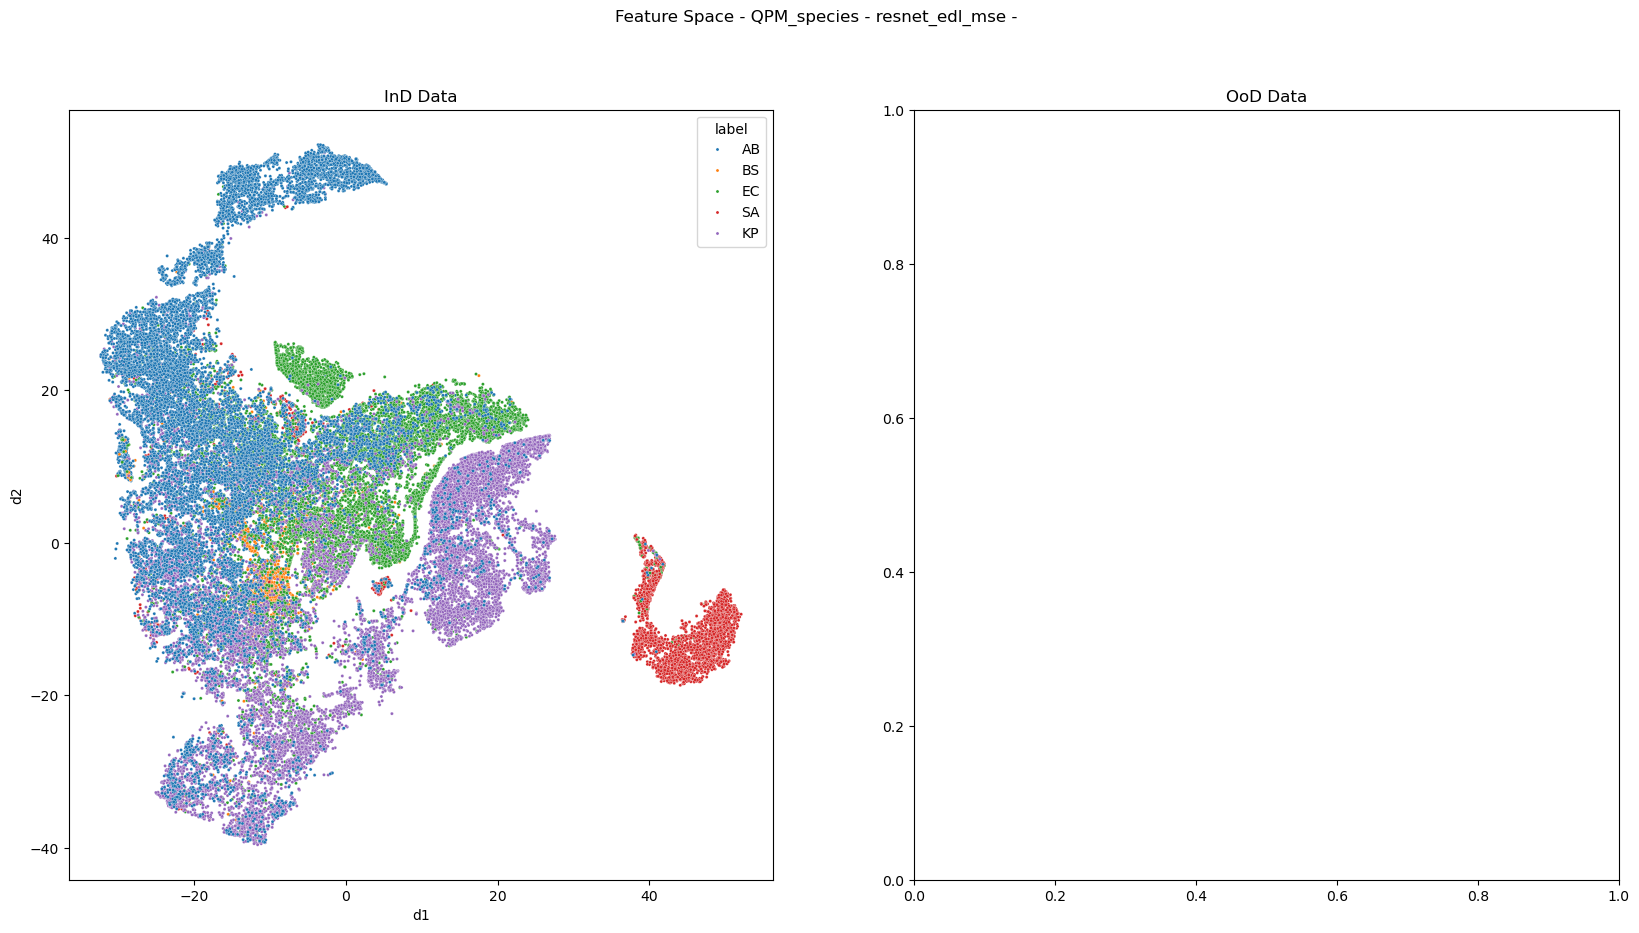

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

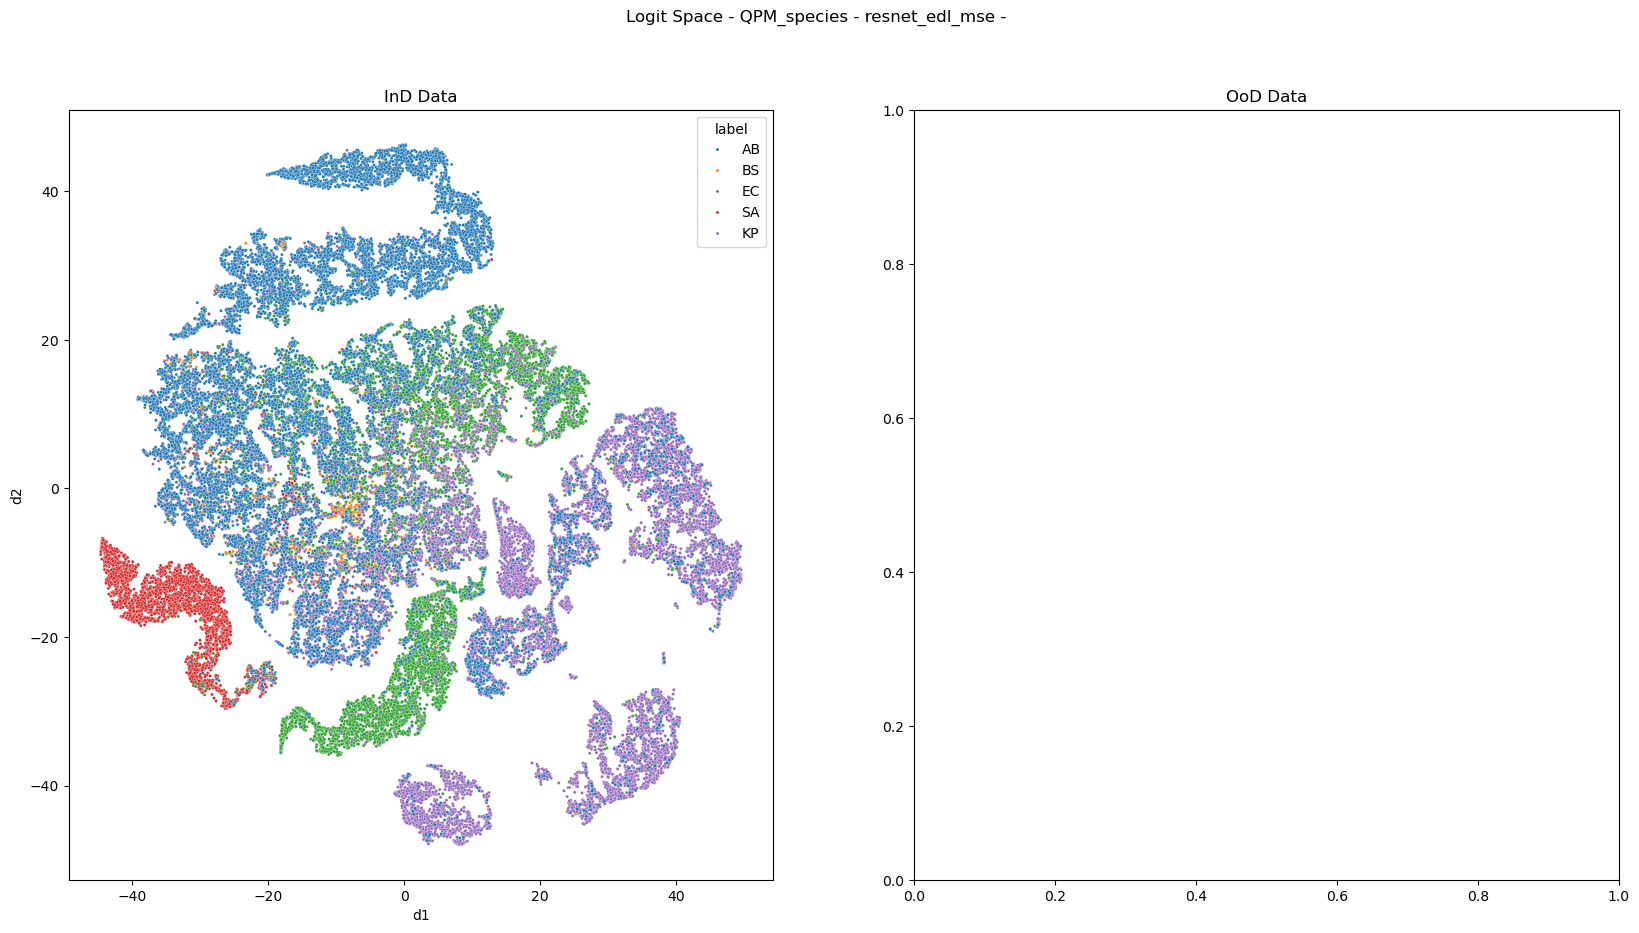

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:49, 16.50s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:33<00:33, 16.54s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:49<00:16, 16.63s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.81s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.72s/it]

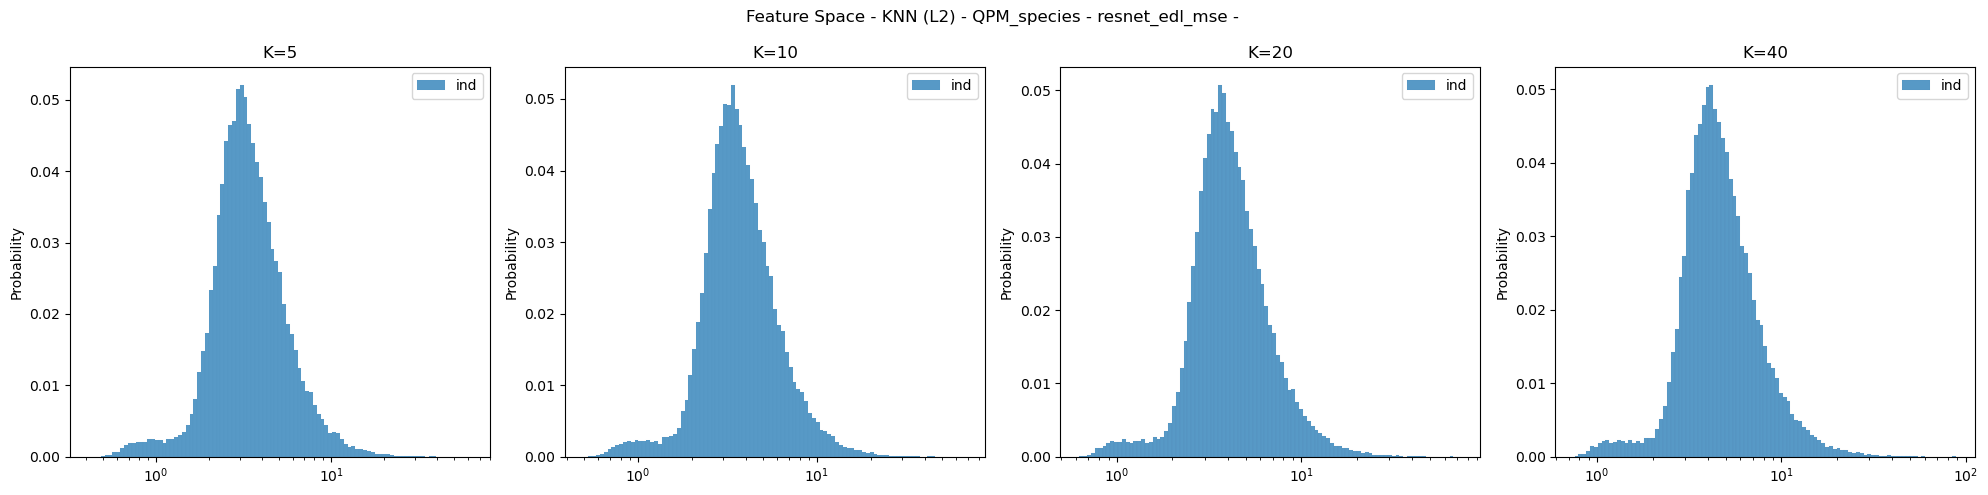

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:16<00:48, 16.16s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:32<00:32, 16.21s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:48<00:16, 16.32s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.53s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.43s/it]

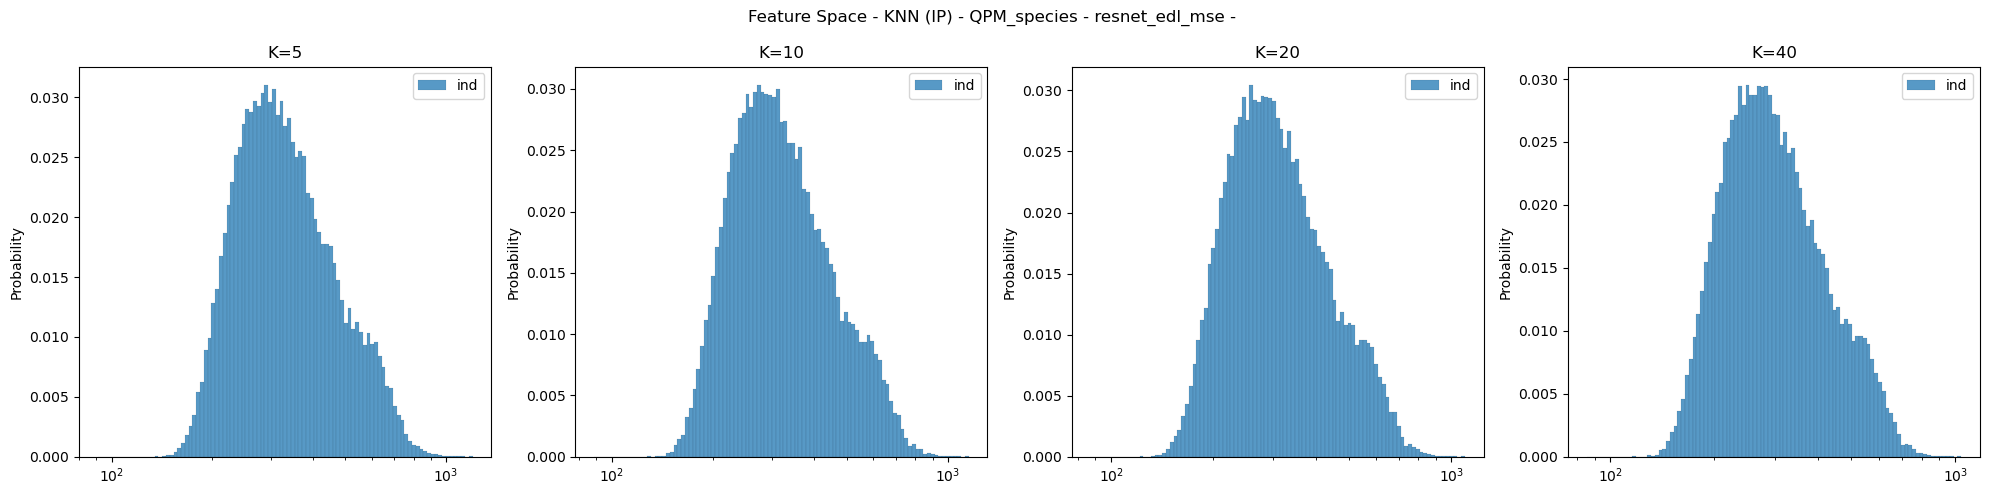

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.26s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.30s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.39s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.57s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]

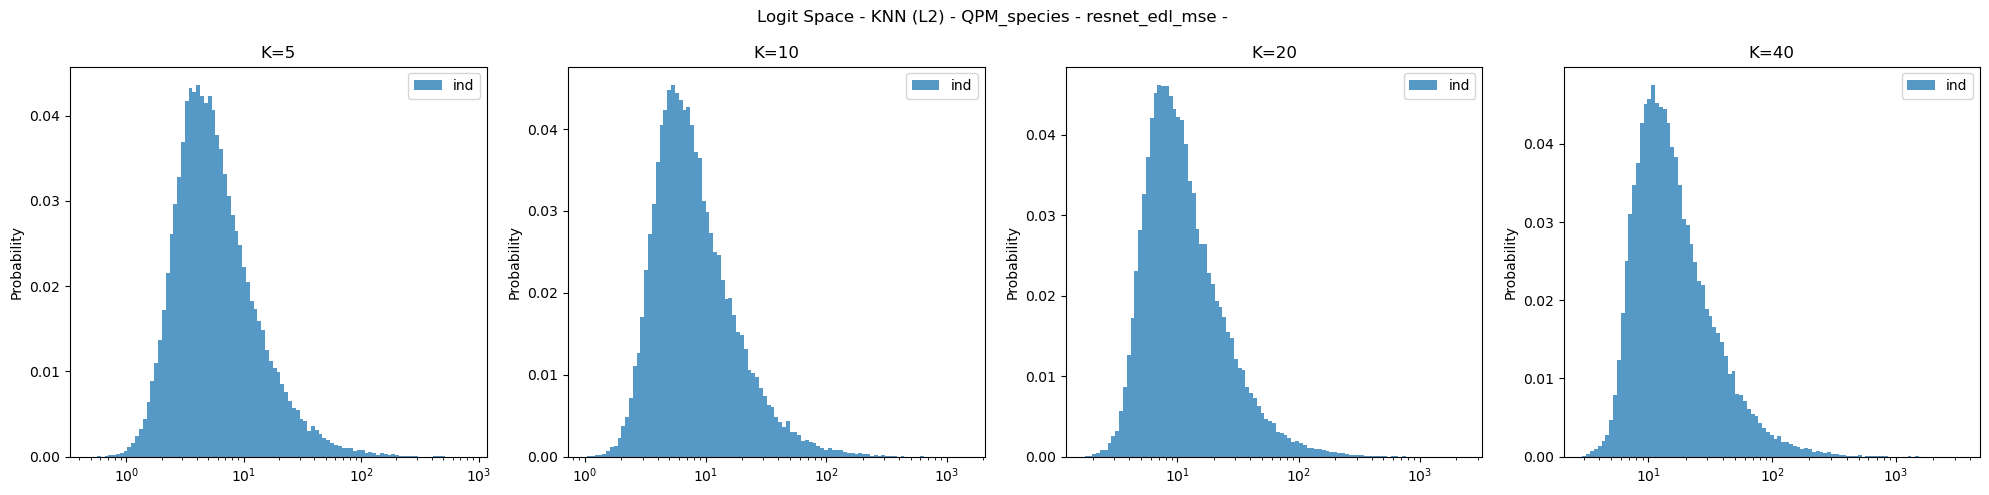

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:06,  2.02s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:04<00:04,  2.14s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:06<00:02,  2.23s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]

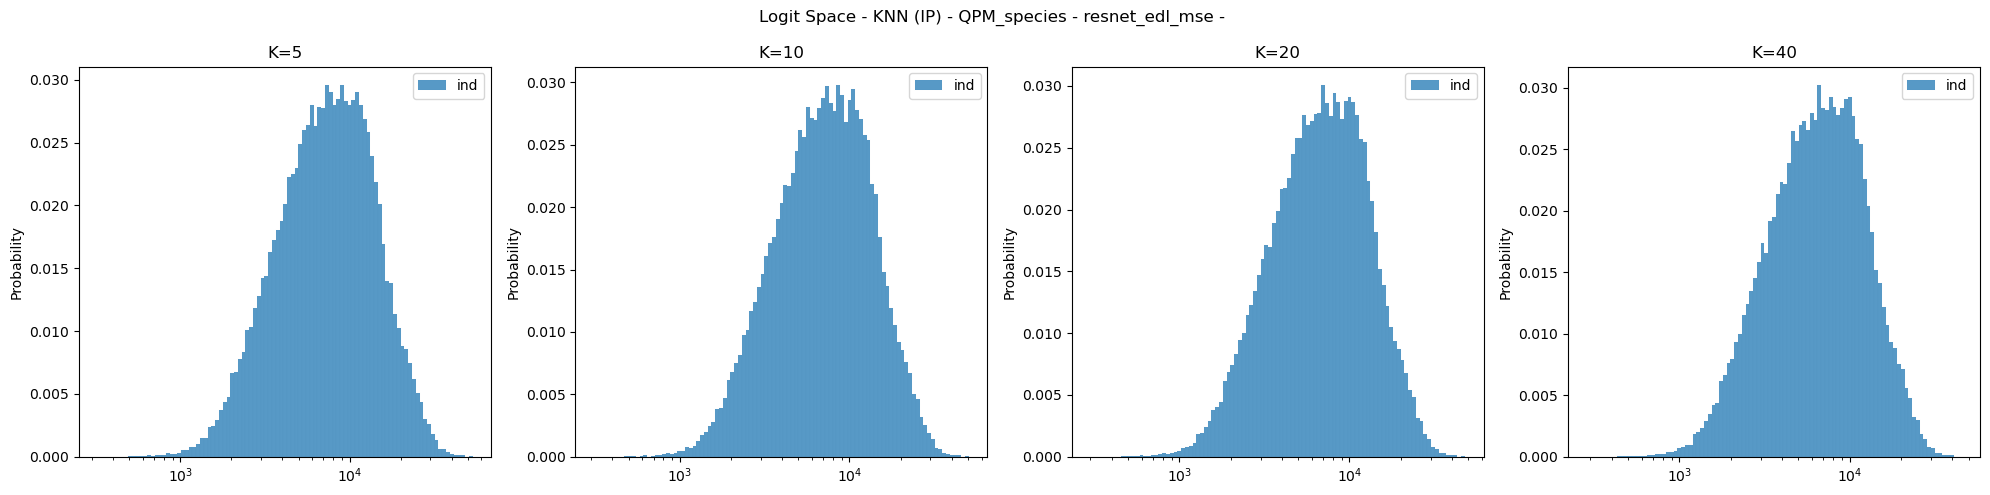

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_799012/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_799012/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)


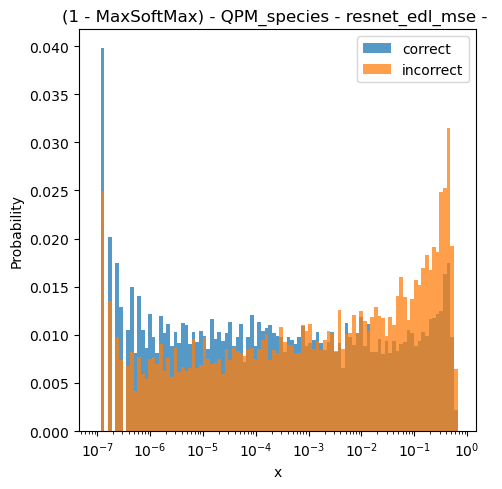

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

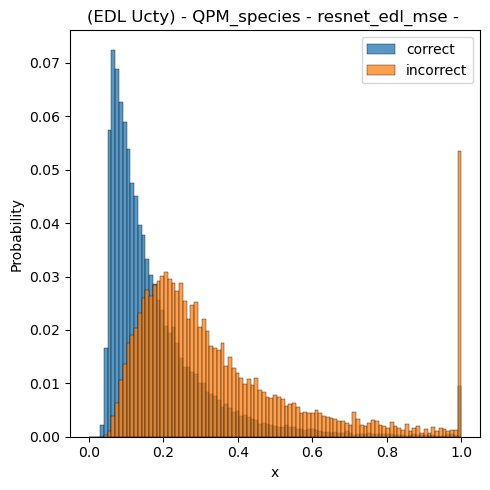

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

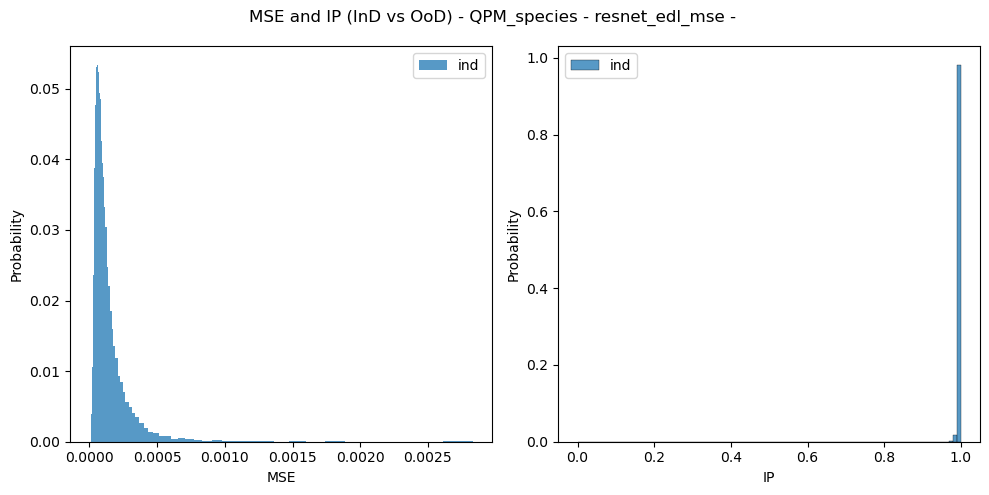

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()